## Imports and setup

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import re
import numpy as np
from time import time
from typing import Literal
from types import FunctionType
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, make_scorer, r2_score, precision_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

# import pickle
import dill as pickle # Fix to allow pickle object containing lambda functions
import hashlib
import json

from codecarbon import EmissionsTracker

from scipy.sparse import vstack

## Util functions and constants

In [145]:
nltk.download('punkt', quiet=True)  # Download the punkt tokenizer for nltk
nltk.download('stopwords', quiet=True)  # Download the stopwords for nltk
nltk.download('punkt_tab', quiet=True)  # Download the WordNet for nltk
nltk.download('omw-1.4', quiet=True)  # Download the WordNet for nltk
nltk.download('averaged_perceptron_tagger_eng', quiet=True)  # Download the POS tagger for nltk
nltk.download('wordnet', quiet=True)  # Download the WordNet for nltk
nltk.download('universal_tagset', quiet=True)

True

In [146]:
RANDOM_STATE = 42

In [ ]:
str_input_text_data_path = os.path.join('inputs', 'pretraitement_texte_images', 'flipkart_com-ecommerce_sample_1050.csv')

In [148]:
def format_label(var_name:str):
	return var_name.replace("_", " ").capitalize() # Replace underscores by white spaces and make the first letter uppercase.

In [ ]:
def draw_top(df:pd.DataFrame, variable:str, top_n:int=15, thing_to_count:str=None, orient='h', show_labels:bool=True, ax=None, **plot_params):
	"""
	Draws a barplot of top values for a given variable of a given dataframe.

	Parameters:
	df (pd.DataFrame): DataFrame to use
	variable (str): Variable for which the top values will be plotted.
	top_n (int): How much values should be plotted
	things_to_count (str): Used to deduce the title of the graph. Can be ommited to keep the title generic (e.g. "Count per Customer city")
	orient (str): Should be either 'h' or 'v'. Other values are equivalent to 'v'. 
				Custom parameter to switch x and y when necessary so that it works properly.
	plot_params (kwargs dict): Other parameters to be passed to barplot method.
	"""

	def handle_plot_orientation(x:str, y:str, orient:str):
		sns.barplot(df, x=x, y=y, ax=ax, legend=False, orient=orient, **plot_params)
		ax.set_xlabel(format_label(x))
		ax.set_ylabel(format_label(y))
		if show_labels:
			for c in ax.containers:
				labels = [(int(v.get_width()) if orient == 'h' else v.get_height()) for v in c]
				labels = [l if l > 0 else "" for l in labels]
				ax.bar_label(c, labels=labels, label_type='edge', padding=2)
	if ax is None:
		fig, ax = plt.subplots(figsize=(10,5))
	df = df[variable].astype(str).value_counts().reset_index() # Get values sorted by their number of occurences. Converting to str prevent seaborn from reordering values if it is numerical for example.
	if top_n is not None: # if top_n is None, plot all the values
		df = df.iloc[:top_n]
		 
	formatted_variable = format_label(variable)
	if orient == 'h': # Handle orientation of graph properly
		handle_plot_orientation(x="count", y=variable, orient='h')
	else:
		handle_plot_orientation(x=variable, y="count", orient='v')
	
	# Create title
	title = f"{f"{thing_to_count} " if thing_to_count is not None else ""}count per {formatted_variable}{f" (top {top_n})" if top_n is not None else ""}"
	
	ax.set_title(title) # Set title
	# sns.despine(ax=ax) # Remove lines enclosing the plot

In [150]:
def draw_tops(df:pd.DataFrame, top_n:int=15, thing_to_count:str=None, max_ncols:int=3, **plot_params):
	"""
	Draws a grid of barplots for all object variables in the DataFrame.
	
	Parameters:
	df (pd.DataFrame): DataFrame to use
	top_n (int): How much values should be plotted for each variable
	thing_to_count (str): Used to deduce the title of the graph. Can be ommited to keep the title generic (e.g. "Count per Customer city")"
	max_ncols (int): Maximum number of columns in the grid
	plot_params (kwargs dict): Other parameters to be passed to barplot method.
	"""
	df_object = df.select_dtypes(include=object)
	if df_object.shape[1] > 0:
		obj_cols = df_object.columns
		n_obj_cols = len(obj_cols)
		n_rows = math.ceil(n_obj_cols/max_ncols)
		n_cols = min(n_obj_cols, max_ncols)
		fig, axes = plt.subplots(n_rows, n_cols, figsize = (n_cols*15, n_rows*8), squeeze=False)
		axes = axes.flatten()
		for col, ax in zip(obj_cols, axes):
			draw_top(df=df_object, variable=col, top_n=top_n, thing_to_count=thing_to_count, orient='h', ax=ax, **plot_params)
		for j in range(n_obj_cols, n_cols*n_rows):
			axes[j].axis("off")
		sns.despine(fig)
		fig.tight_layout()
	else:
		print("No object variable in this DataFrame.")
	# Truncate y-axis tick labels if they exceed 20 characters
	for ax in axes[:n_obj_cols]:
		labels = [label.get_text() for label in ax.get_yticklabels()]
		truncated_labels = [f"{label[:20]}..." if len(label) > 20 else label for label in labels]
		ax.set_yticks(range(len(truncated_labels)))
		ax.set_yticklabels(truncated_labels)

In [151]:
def visualize_smth(df:pd.DataFrame, x:str="order_purchase_timestamp", y=None, date_format:str='%Y-%m-%d %H:%M:%S', suptitle:str="Title", method=sns.displot, subplot_params:dict={}, **plot_params):
    """
    Visualizes a DataFrame using seaborn's displot or similar methods.
    
    Parameters:
    df (pd.DataFrame): DataFrame to visualize.
	x (str): Column name for the x-axis. Defaults to "order_purchase_timestamp".
	y (str): Column name for the y-axis. If None, only x-axis will be plotted.
    date_format (str): Format for parsing dates in the x-axis. Defaults to '%Y-%m-%d %H:%M:%S'.
    suptitle (str): Title for the plot.
    method (function): Seaborn plotting function to use, e.g., sns.displot.
    subplot_params (dict): Additional parameters for the subplot.
    plot_params (dict): Additional parameters for the plotting function.
	"""
    data = df.copy()
    try:
        # Convert event_date from string to datetime
        data[x] = pd.to_datetime(data[x], format=date_format, errors='raise')
    except Exception:
        print("Data on X axis will not be considered as a date.")
    finally:
        data = data.sort_values(by=x)
        data = data.reset_index(drop=True)
    
    def wrapper(**params):
        ax = plt.gca()
        ax.tick_params(axis='x', labelrotation=90, labelbottom=True)

    method_type = type(method())
    plt.close()
    if method_type == sns.axisgrid.FacetGrid:
        g = method(data=data, x=x, y=y, **plot_params, **subplot_params)
    else:
        g = sns.FacetGrid(data=data, **plot_params)
        g.map_dataframe(func=method, x=x, y=y, **subplot_params)
    g.map_dataframe(func=wrapper)
    g.figure.suptitle(suptitle, y=1)
    g.tight_layout()
    plt.show()

In [152]:
def draw_distributions(df:pd.DataFrame, max_ncols:int=3, **plot_params):
	"""
	Draws a grid of histograms for all numerical variables in the DataFrame.

	Parameters:
	df (pd.DataFrame): DataFrame to use
	max_ncols (int): Maximum number of columns in the grid
	plot_params (kwargs dict): Other parameters to be passed to histplot method.
	"""
	df_numerical = df.select_dtypes(exclude=object)
	if df_numerical.shape[1] > 0:
		numerical_cols = df_numerical.columns
		n_numerical_cols = len(numerical_cols)
		n_rows = math.ceil(n_numerical_cols/max_ncols)
		n_cols = min(n_numerical_cols, max_ncols)
		fig, axes = plt.subplots(n_rows, n_cols, figsize = (n_cols*7, n_rows*5))
		axes = axes.flatten()
		for col, ax in zip(numerical_cols, axes):
			formatted_col = format_label(col)
			sns.histplot(df_numerical[col], ax = ax, **plot_params)
			ax.set_title(f"Distribution of {formatted_col}")
			ax.set_xlabel(formatted_col)
		for j in range(n_numerical_cols, n_cols*n_rows):
			axes[j].axis("off")
		plt.tight_layout()
	else:
		print("No numerical variable in this DataFrame.")

In [153]:
def draw_top_categories(df:pd.DataFrame, variable:str="category_level_1", top_n:int=15, thing_to_count:str="Word", criteria:str="n_words", figsize=(8,4), **plot_params):
	"""
	Draws a barplot of top categories for a given DataFrame.
	
	Parameters:
	df (pd.DataFrame): DataFrame to use
	top_n (int): How much values should be plotted
	thing_to_count (str): Used to deduce the title of the graph. Can be ommited to keep the title generic (e.g. "Count per Customer city")
	criteria (str): Column name to use for counting, e.g. "n_words"
	plot_params (kwargs dict): Other parameters to be passed to barplot method.
	"""
	if "ax" in plot_params:
		ax = plot_params.pop("ax")
	else:
		fig, ax = plt.subplots(figsize=figsize)
	if "order" not in plot_params:
		order = list(df.groupby(variable)[criteria].sum().sort_values(ascending=False).index)
		plot_params["order"] = order
	plot_params["order"] = plot_params["order"][:top_n]  # Limit the order to top_n categories
	if "estimator" not in plot_params:
		plot_params["estimator"] = 'sum'
	sns.barplot(data=df, x=criteria, y=variable, ax=ax, **plot_params)
	formatted_variable = format_label(variable)
	title = f"{f"{thing_to_count} " if thing_to_count is not None else ""}count per {formatted_variable}{f" (top {top_n})" if top_n is not None else ""}"
	ax.set_title(title)
	ax.set_xlabel(format_label(criteria))
	ax.set_ylabel(formatted_variable)
	ax.legend(loc='upper left', bbox_to_anchor=(1.05,1))

In [154]:
def draw_top_categories_all_levels(df:pd.DataFrame, criteria:str="n_words", other_criteria:str=None):
	"""
	Draws top categories for all levels in the product_category_tree. Also allows to display the top categories based on another criteria to visualize the difference with transparency
	"""
	num_levels = df["product_category_tree"].str.count(" >> ").max() + 1  # Count the number of " >> " to determine the number of levels
	for i in range(1, num_levels+1):
		# Draw top categories for each level
		fig, ax = plt.subplots(figsize=(8, 4))
		draw_top_categories(df, variable=f"category_level_{i}", hue="category_level_1" if i > 1 else None, top_n=15, thing_to_count="Word", dodge=False, criteria=criteria, errorbar=None, orient='h', palette='tab10' if i > 1 else None, ax=ax)
		if other_criteria is not None:
			draw_top_categories(df, variable=f"category_level_{i}", hue="category_level_1" if i > 1 else None, top_n=15, thing_to_count="Word", dodge=False, criteria=other_criteria, errorbar=None, orient='h', palette='tab10' if i > 1 else None, alpha=0.5, order=[t.get_text() for t in ax.get_yticklabels()], ax=ax, legend=False)


## Exploration

In [ ]:
text_data = pd.read_csv(str_input_text_data_path, encoding='utf-8')
text_data["crawl_timestamp"] = pd.to_datetime(text_data["crawl_timestamp"], format='%Y-%m-%d %H:%M:%S +0000')
text_data["product_rating"] = text_data["product_rating"].replace('No rating available', None)  # Replace 'Not Rated' with None
text_data["overall_rating"] = text_data["overall_rating"].replace('No rating available', None)  # Replace 'Not Rated' with None
text_data["product_rating"] = text_data["product_rating"].astype(float)
text_data["overall_rating"] = text_data["overall_rating"].astype(float)

In [156]:
text_data.dtypes

uniq_id                            object
crawl_timestamp            datetime64[ns]
product_url                        object
product_name                       object
product_category_tree              object
pid                                object
retail_price                      float64
discounted_price                  float64
image                              object
is_FK_Advantage_product              bool
description                        object
product_rating                    float64
overall_rating                    float64
brand                              object
product_specifications             object
dtype: object

In [157]:
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   uniq_id                  1050 non-null   object        
 1   crawl_timestamp          1050 non-null   datetime64[ns]
 2   product_url              1050 non-null   object        
 3   product_name             1050 non-null   object        
 4   product_category_tree    1050 non-null   object        
 5   pid                      1050 non-null   object        
 6   retail_price             1049 non-null   float64       
 7   discounted_price         1049 non-null   float64       
 8   image                    1050 non-null   object        
 9   is_FK_Advantage_product  1050 non-null   bool          
 10  description              1050 non-null   object        
 11  product_rating           161 non-null    float64       
 12  overall_rating           161 non-n

In [158]:
text_data.describe(include='all')

uniq_id                crawl_timestamp  \
count                               1050                           1050   
unique                              1050                            NaN   
top     55b85ea15a1536d46b7190ad6fff8ce7                            NaN   
freq                                   1                            NaN   
mean                                 NaN  2016-01-22 20:35:46.106666752   
min                                  NaN            2015-12-01 06:13:00   
25%                                  NaN            2015-12-01 12:40:44   
50%                                  NaN            2016-01-01 10:55:30   
75%                                  NaN     2016-03-03 10:08:31.500000   
max                                  NaN            2016-06-26 14:21:24   
std                                  NaN                            NaN   

                                              product_url  \
count                                                1050   
unique                                               1050   
top     http://www.flipkart.com/elegance-polyester-mul...   
freq                                                    1   
mean                                                  NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   
std                                                   NaN   

                                             product_name  \
count                                                1050   
unique                                               1050   
top     Elegance Polyester Multicolor Abstract Eyelet ...   
freq                                                    1   
mean                                                  NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   
std                                                   NaN   

                                    product_category_tree               pid  \
count                                                1050              1050   
unique                                                642              1050   
top     ["Home Furnishing >> Bed Linen >> Blankets, Qu...  CRNEG7BKMFFYHQ8Z   
freq                                                   56                 1   
mean                                                  NaN               NaN   
min                                                   NaN               NaN   
25%                                                   NaN               NaN   
50%                                                   NaN               NaN   
75%                                                   NaN               NaN   
max                                                   NaN               NaN   
std                                                   NaN               NaN   

         retail_price  discounted_price                                 image  \
count     1049.000000       1049.000000                                  1050   
unique            NaN               NaN                                  1050   
top               NaN               NaN  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
freq              NaN               NaN                                     1   
mean      2186.197331       1584.527169                                   NaN   
min         35.000000         35.000000                                   NaN   
25%        555.000000        340.000000                                   NaN   
50%        999.000000        600.000000                              

c:\Git-OpenClassrooms\DS_6\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


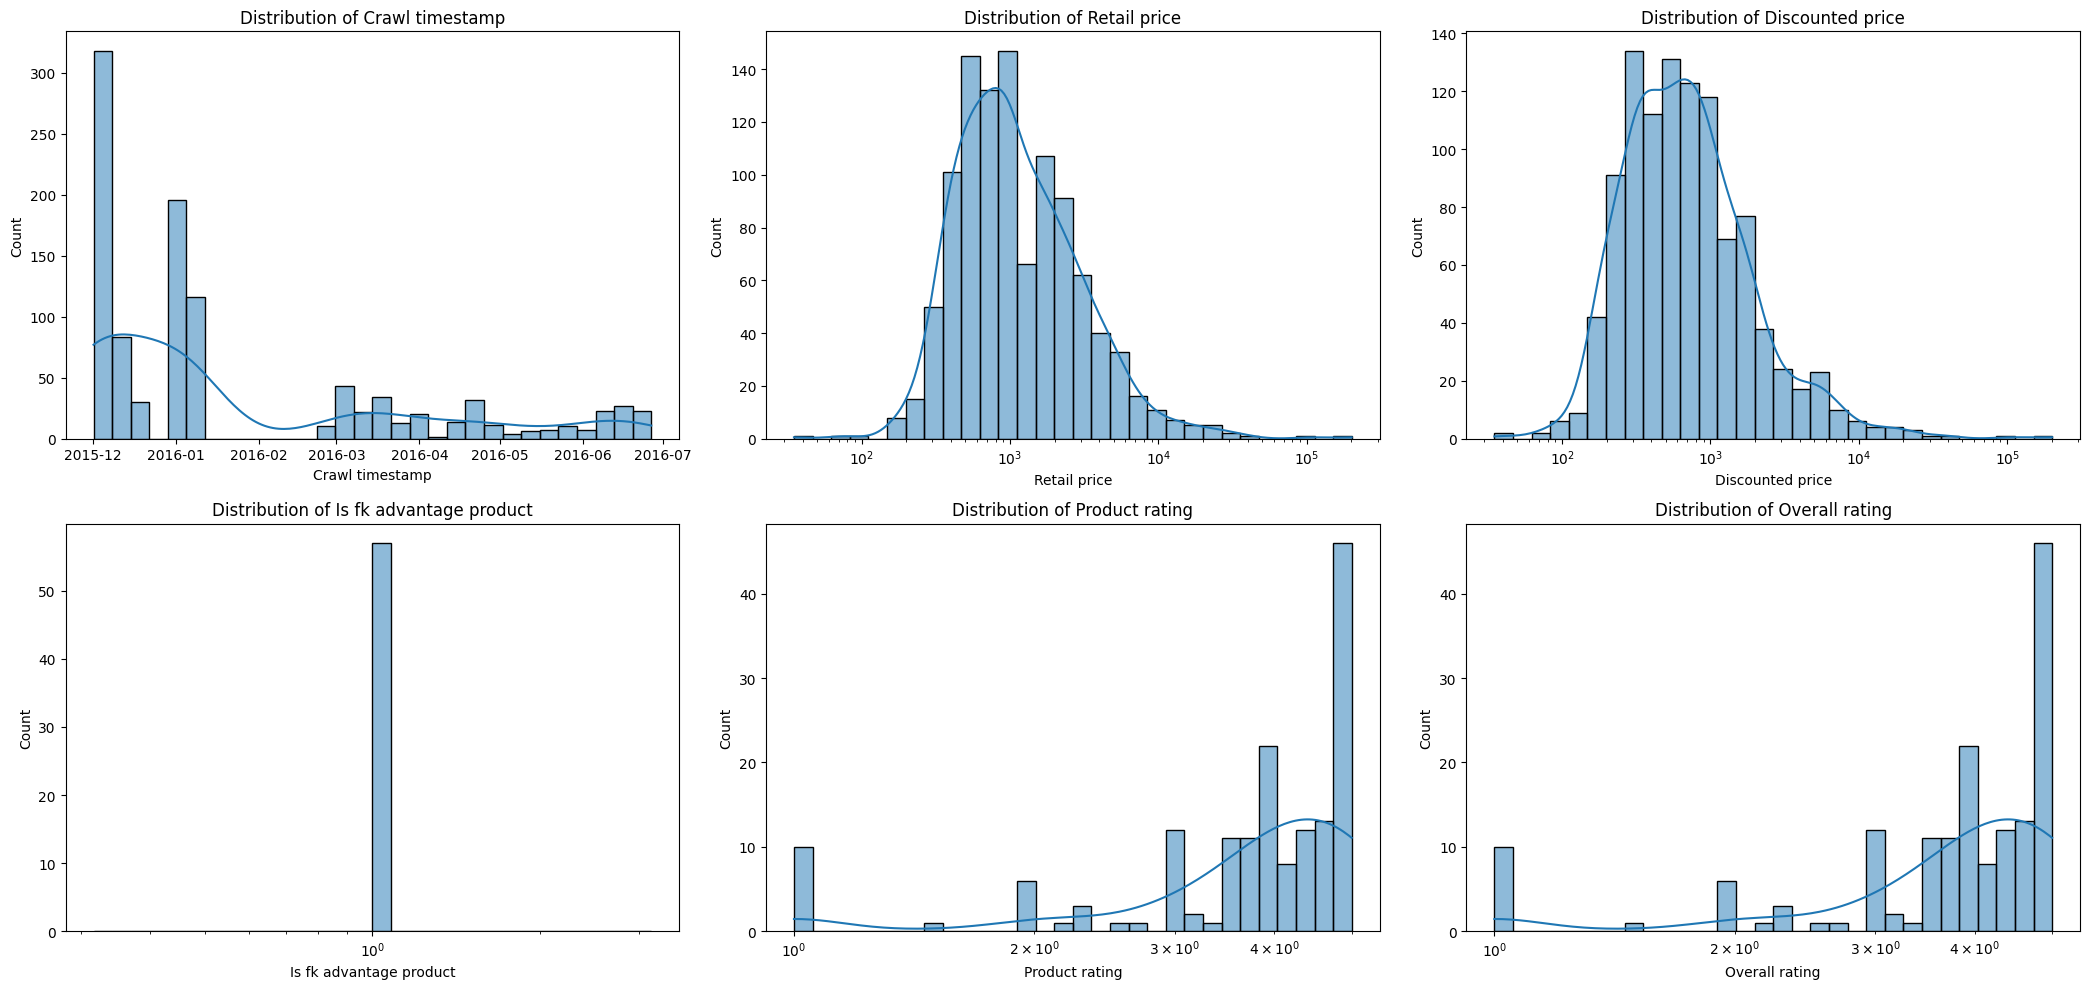

In [159]:
draw_distributions(text_data, max_ncols=3, kde=True, bins=30, log_scale=True)

) missing from font(s) DejaVu Sans.p\ipykernel_15220\130532689.py:25: UserWarning: Glyph 13 (
  fig.tight_layout()
C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\130532689.py:25: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.tight_layout()
C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\130532689.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


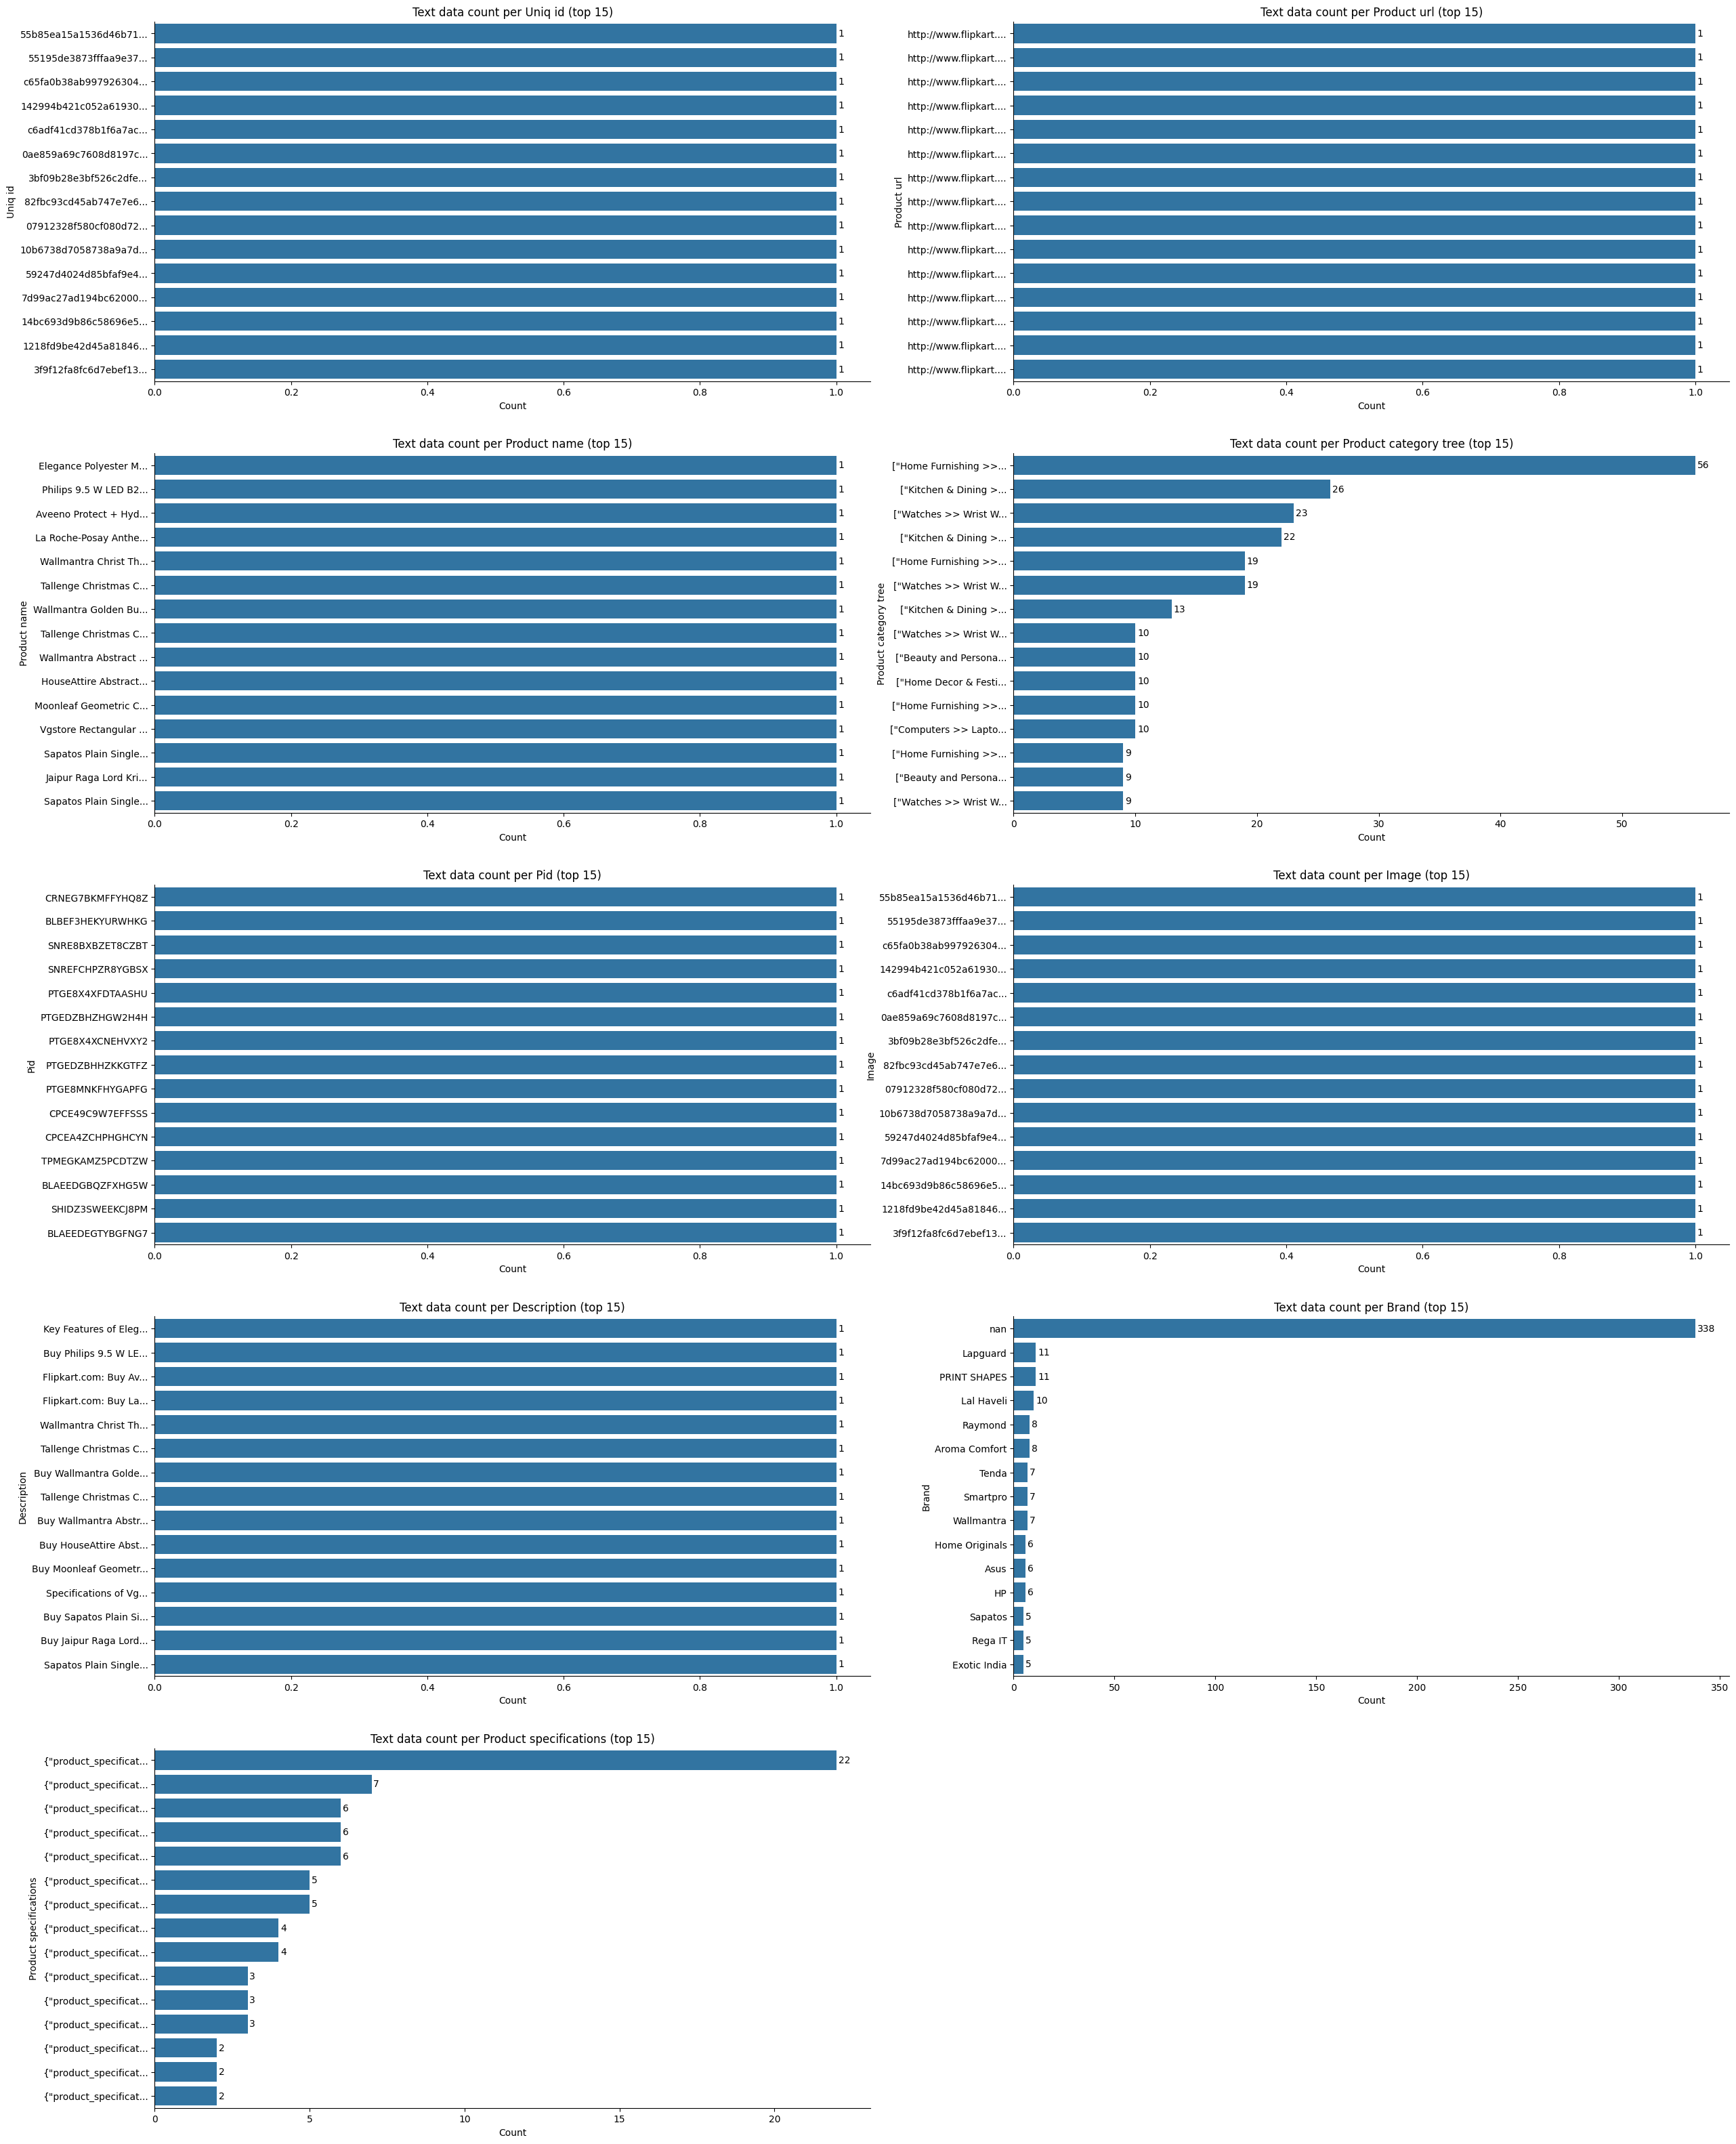

In [160]:
draw_tops(text_data, top_n=15, thing_to_count="Text data", max_ncols=2)

## Normalize

In [161]:
def normalize_text(text:str, pattern:str=r'\w+'):
	r"""
	Normalize text by removing special characters and converting to lowercase.
	
	Parameters:
	text (str): Input text to normalize.
	pattern (str): Regular expression pattern to match words. Defaults to r'\w+' which matches word characters.
	
	Returns:
	str: Normalized text.
	"""
	return [word.lower() for word in nltk.regexp_tokenize(text, pattern=pattern)]

In [162]:
# Add category levels to the DataFrame
product_categories = text_data["product_category_tree"].str.strip(r"[\[\]\"]").str.split(" >> ", expand=True)  # Remove brackets from the product_category_tree and split into multiple columns
product_categories.rename(columns=lambda x: f"category_level_{x+1}", inplace=True)
product_categories.fillna("No category", inplace=True)  # Fill NaN values with "No category"
columns_to_add = set(product_categories.columns) - set(text_data.columns)
text_data = pd.concat([text_data, product_categories[sorted(list(columns_to_add))]], axis=1)

In [163]:
text_data

uniq_id     crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7 2016-04-30 03:22:56   
1     7b72c92c2f6c40268628ec5f14c6d590 2016-04-30 03:22:56   
2     64d5d4a258243731dc7bbb1eef49ad74 2016-04-30 03:22:56   
3     d4684dcdc759dd9cdf41504698d737d8 2016-06-20 08:49:52   
4     6325b6870c54cd47be6ebfbffa620ec7 2016-06-20 08:49:52   
...                                ...                 ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc 2015-12-01 10:15:43   
1046  fd6cbcc22efb6b761bd564c28928483c 2015-12-01 10:15:43   
1047  5912e037d12774bb73a2048f35a00009 2015-12-01 10:15:43   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6 2015-12-01 10:15:43   
1049  f2f027ad6a6df617c9f125173da71e44 2015-12-01 10:15:43   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049        1190.0             595.0  f2f027ad6a6df617c9f125173da71e44.jpg   

      

In [164]:
text_data["tokenized"] = text_data["description"].apply(normalize_text, pattern=r'[\w]+')
text_data["n_words"] = text_data["tokenized"].apply(len)
text_data["n_unique_words"] = text_data["tokenized"].apply(lambda x: len(set(x)))

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\4264656836.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1.05,1))


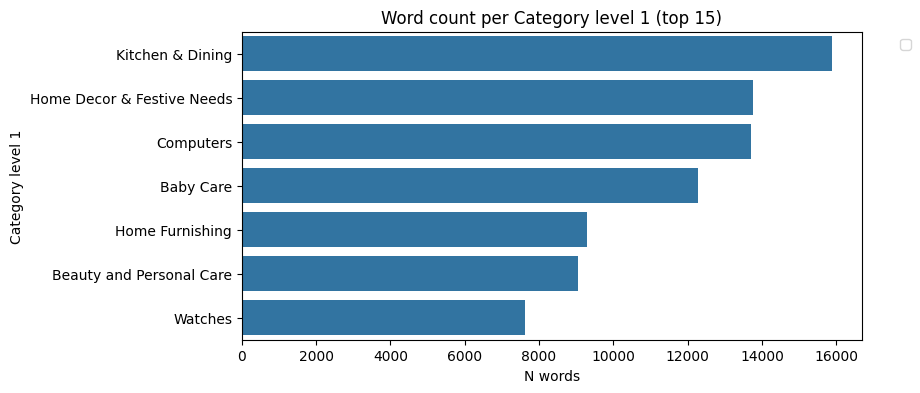

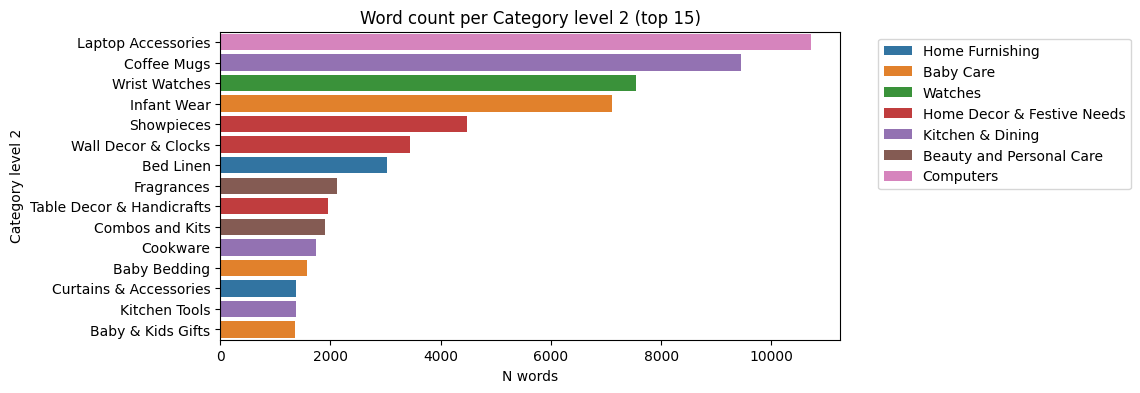

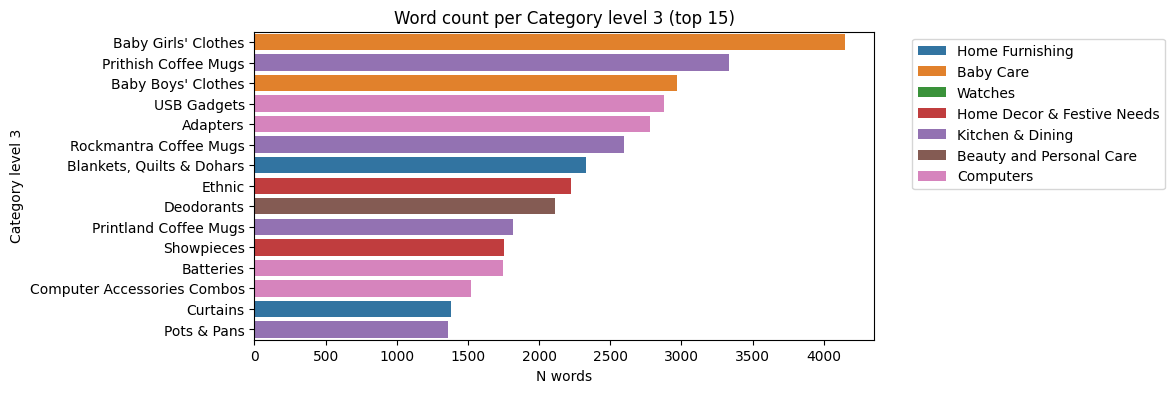

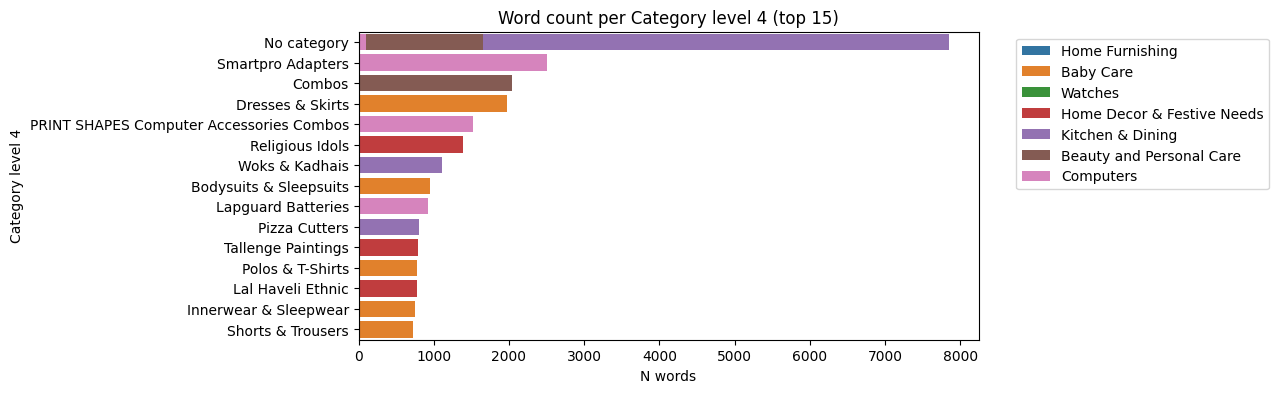

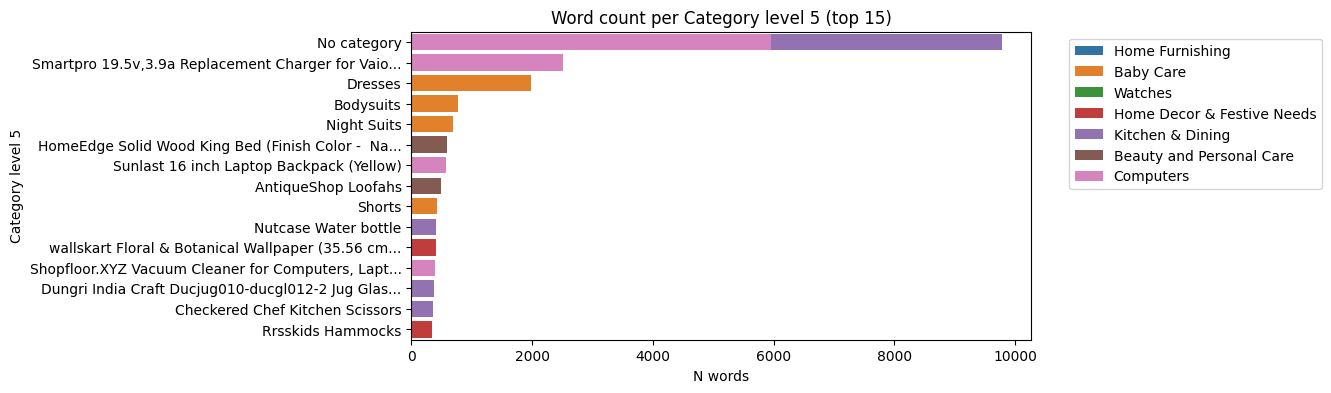

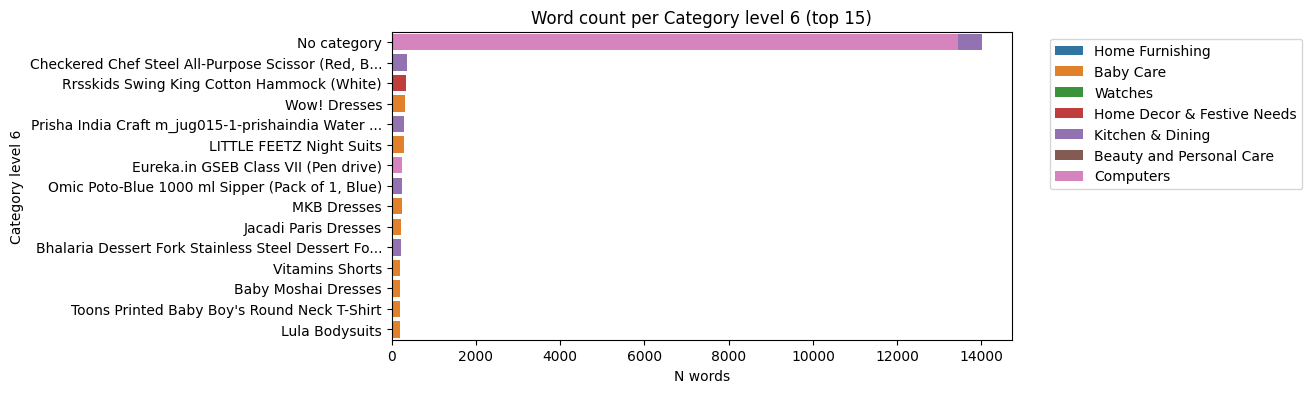

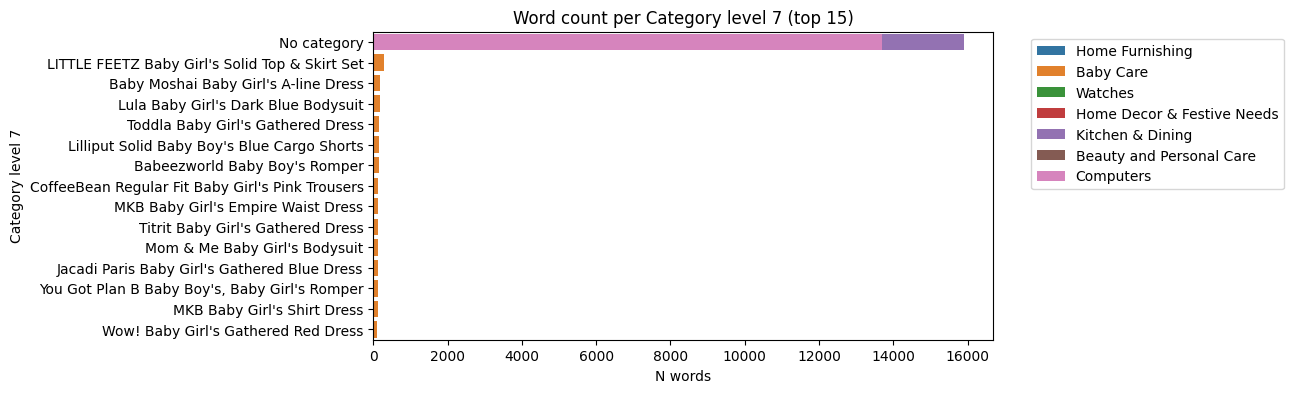

In [165]:
draw_top_categories_all_levels(text_data)

## Remove stopwords

In [166]:
def draw_pareto(df:pd.DataFrame, categories:str, count_col:str='count', hline:float=None, vline:float=None, ax=None, **histplot_params):
	"""
	Draws a Pareto chart for the given DataFrame.
	
	Parameters:
	df (pd.DataFrame): DataFrame to use
	"""
	if count_col not in df.columns:
		print(f"Column '{count_col}' not found in DataFrame. Using 'value_counts' method instead.")
		df = df.value_counts(categories).reset_index(name=count_col)
		count_col = 'count'
	else:
		df = df.groupby(categories)[[count_col]].sum()
		df = df.sort_values(by=count_col, ascending=False)	
	df['cumulative_count'] = df[count_col].cumsum()
	df['cumulative_percentage'] = 100 * df['cumulative_count'] / df[count_col].sum()

	if ax is None:
		fig, ax1 = plt.subplots(figsize=(10, 6))
	else:
		ax1=ax
	if df.shape[0] > 50:
		x = range(1, df.shape[0]+1)
	else:
		x = df.index
	sns.histplot(data=df, x=x, weights=count_col, ax=ax1, color='lightblue', label='Count', **histplot_params)
	ax1.set_ylabel('Count', color='blue')
	ax1.tick_params(axis='y', labelcolor='blue')
	ax1.tick_params(axis='x', rotation=90)

	ax2 = ax1.twinx()
	ax2.set_ylim(bottom = 0, top=110)
	sns.lineplot(data=df, x=x, y="cumulative_percentage", ax=ax2, color='red', label='Cumulative Percentage', legend=False)
	ax2.set_ylabel('Cumulative Percentage (%)', color='red')
	ax2.tick_params(axis='y', labelcolor='red')

	ax1.set_xlabel('Category count')
	ax1.set_title(f"Pareto Chart: '{format_label(count_col)}' relative to '{format_label(categories)}'")

	if hline is not None:
		hline = min(hline, df[count_col].max())  # Ensure hline does not exceed max count
		if hline > 1:
			ax1.axhline(y=hline, color='green', linestyle='--', label=f'Count = {hline}')
		else:
			ax2.axhline(y=hline*100, color='green', linestyle='--', label=f'Cumulative % = {hline*100}%')
	if vline is not None:
		vline = min(vline, len(x)-1)  # Ensure hline does not exceed max count
		if vline > 1:
			ax1.axvline(x=x[vline], color='green', linestyle='--', label=f'Category count = {vline}')
		else:
			ax2.axvline(x=np.quantile(range(len(x)), vline), color='green', linestyle='--', label=f'Categories % = {vline*100}%')

	handles1, labels1 = ax1.get_legend_handles_labels()
	handles2, labels2 = ax2.get_legend_handles_labels()	
	ax1.legend(handles=handles1+handles2, labels=labels1+labels2, loc='lower right')
	plt.show()

In [167]:
def get_most_used_words(df:pd.DataFrame=text_data, tokens_col:str="tokenized", threshold_words:int=0.05, plot:bool=True, **histplot_params):
	"""
	Draws a Pareto chart of the most used words in the description.
	
	Parameters:
	text_data (pd.DataFrame): DataFrame containing the tokenized text data.
	tokens_col (str): Column name containing the tokenized words.
	threshold_words (int): Threshold for the number of words considered as stopwords.
	"""
	most_used_words = df[tokens_col].explode().value_counts().reset_index()
	most_used_words.columns = ["word", "count"]

	if plot:
		fig, axes = plt.subplots(2, 1, figsize=(10, 15))
		sns.barplot(data=most_used_words.head(50), x="count", y="word", ax=axes[0])
		axes[0].tick_params(axis='y', labelsize=8)
		
		draw_pareto(most_used_words, categories="word", count_col='count', hline=0.5, vline=threshold_words, ax=axes[1], **histplot_params)

	return set(most_used_words["word"].head(50))

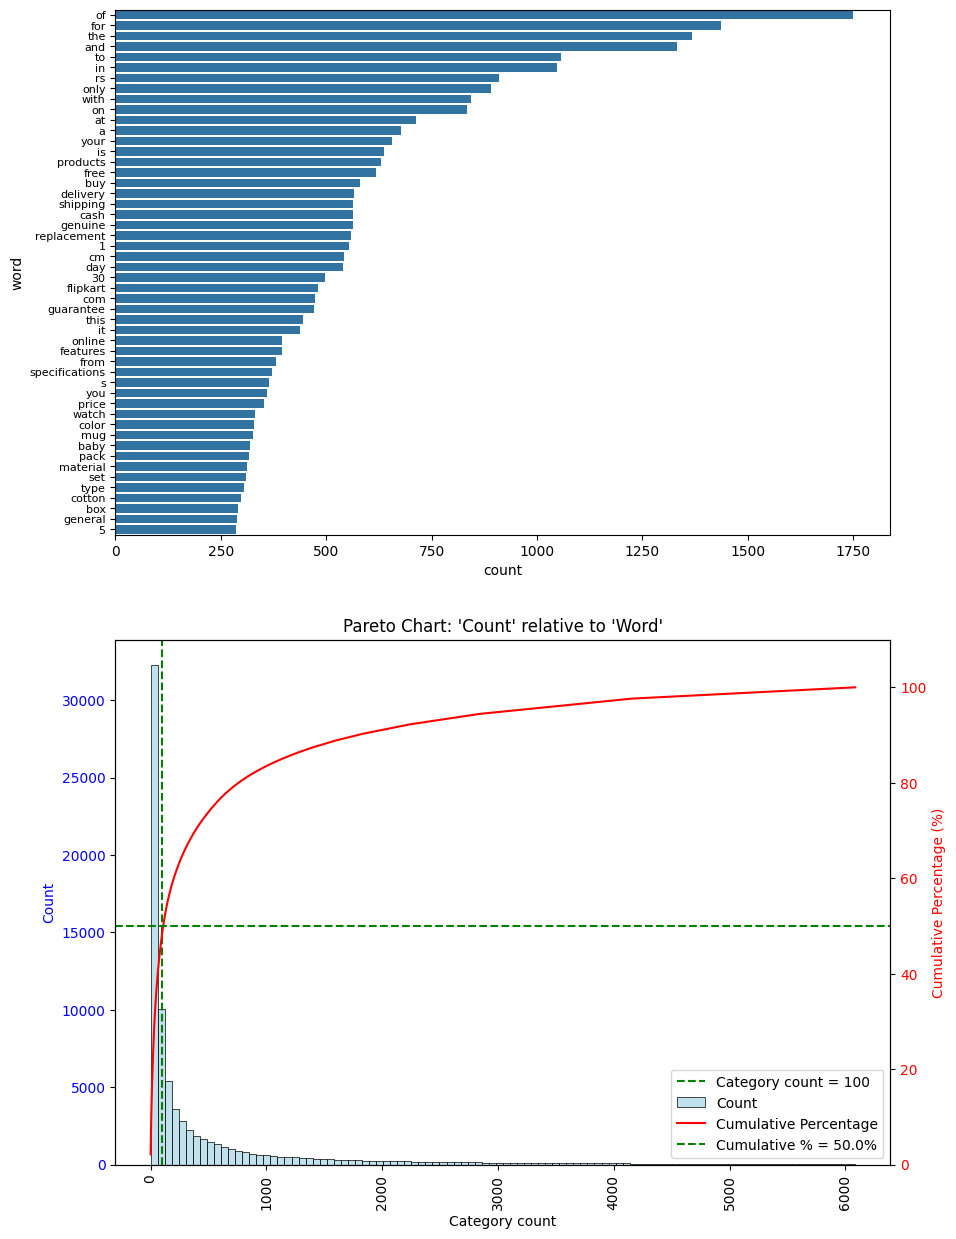

Adding the 100 most common words in the corpus as stopwords. Number of stopwords: 50
Adding the usual stopwords. Number of stopwords: 230


In [168]:
stopwords = get_most_used_words(df=text_data, tokens_col="tokenized", threshold_words=100, bins=100)
print(f"Adding the 100 most common words in the corpus as stopwords. Number of stopwords: {len(stopwords)}")
stopwords.update(tuple(nltk.corpus.stopwords.words('english')))
print(f"Adding the usual stopwords. Number of stopwords: {len(stopwords)}")

In [169]:
def normalize_text_remove_stopwords(text:str, pattern:str=r'\w+', stopwords:set=stopwords):
	r"""
	Normalize text by removing special characters, converting to lowercase, and removing stopwords.
	
	Parameters:
	text (str): Input text to normalize.
	pattern (str): Regular expression pattern to match words. Defaults to r'\w+' which matches word characters.
	stopwords (set): Set of stopwords to remove from the text. Defaults to the global stopwords set.
	
	Returns:
	list: List of normalized words without stopwords.
	"""
	return [word.lower() for word in normalize_text(text, pattern=pattern) if word.lower() not in stopwords]

In [170]:
text_data["tokenized_no_sw"] = text_data["description"].apply(normalize_text_remove_stopwords)
text_data["n_words_no_sw"] = text_data["tokenized_no_sw"].apply(len)
text_data["n_unique_words_no_sw"] = text_data["tokenized_no_sw"].apply(lambda x: len(set(x)))

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\4264656836.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1.05,1))
C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\4264656836.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1.05,1))


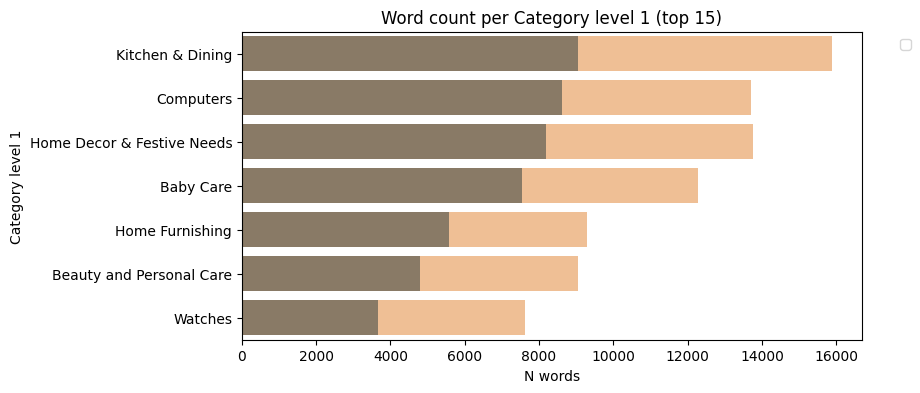

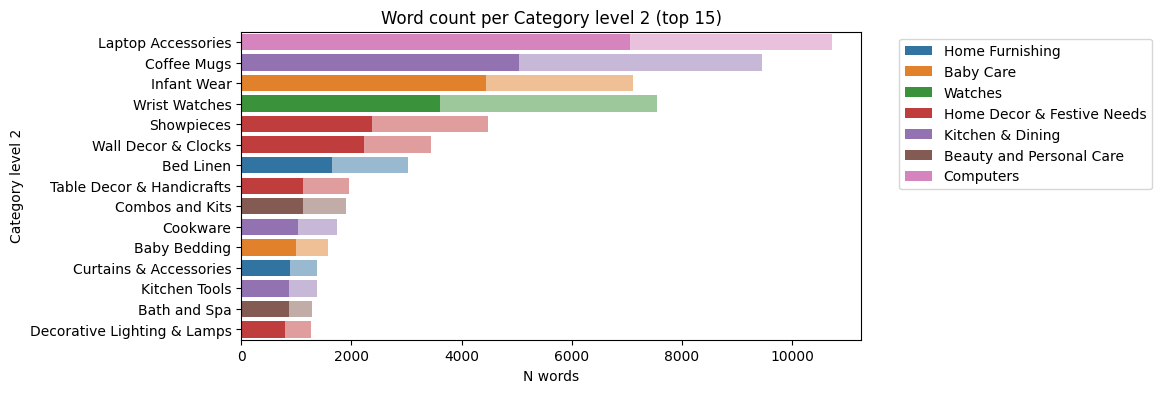

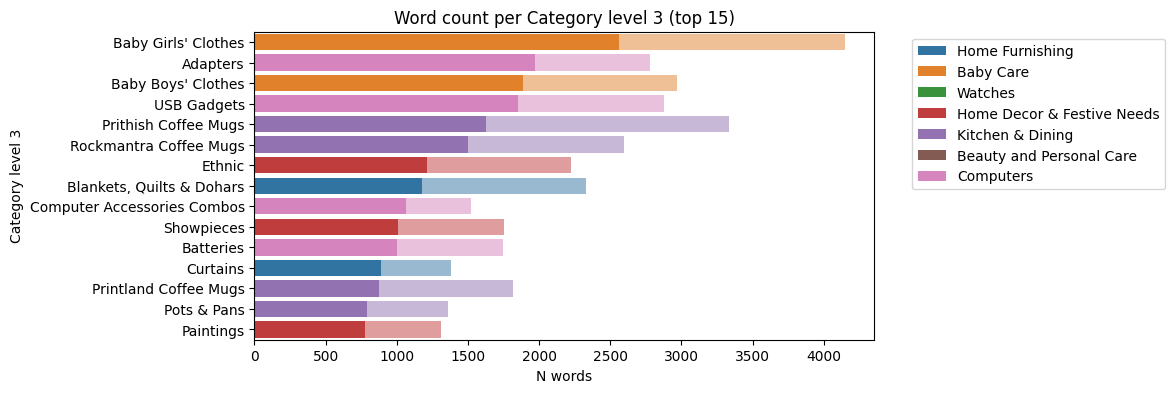

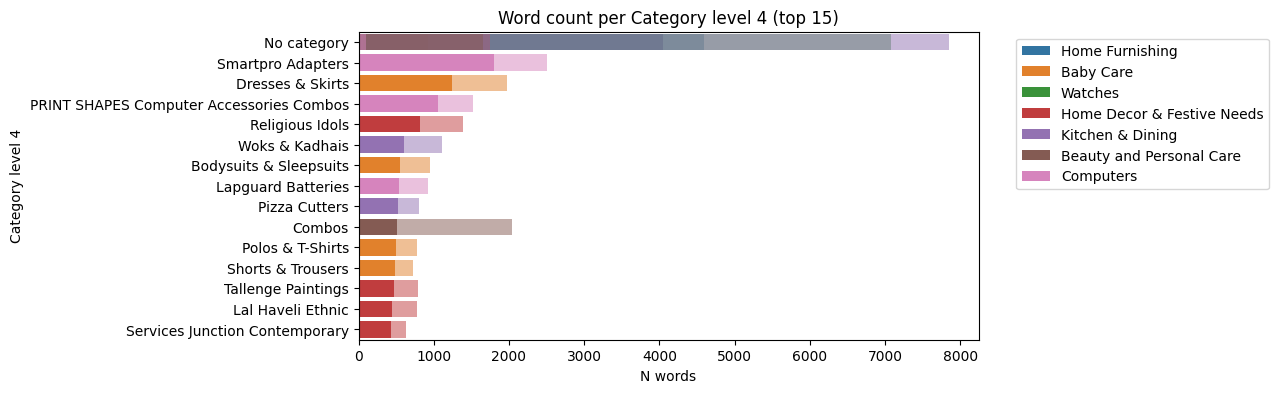

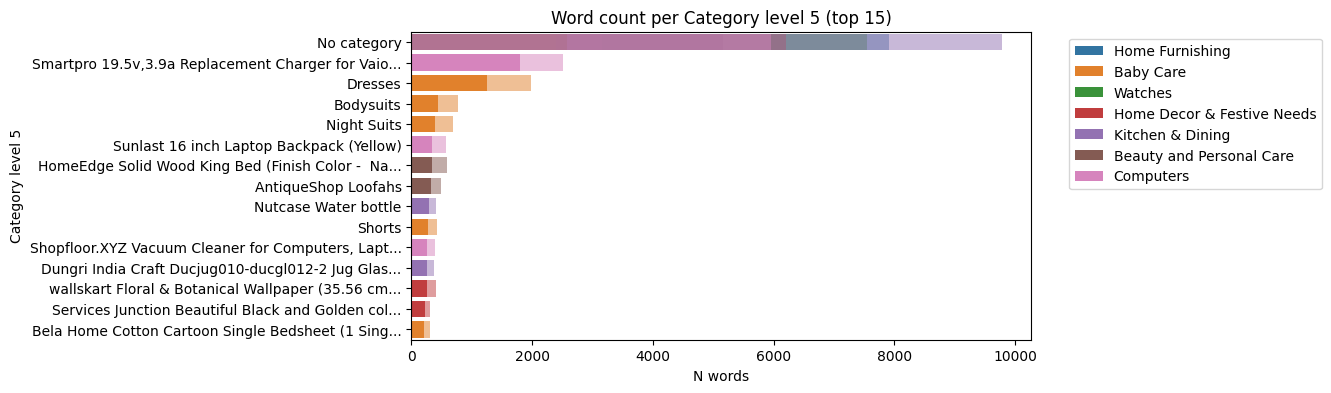

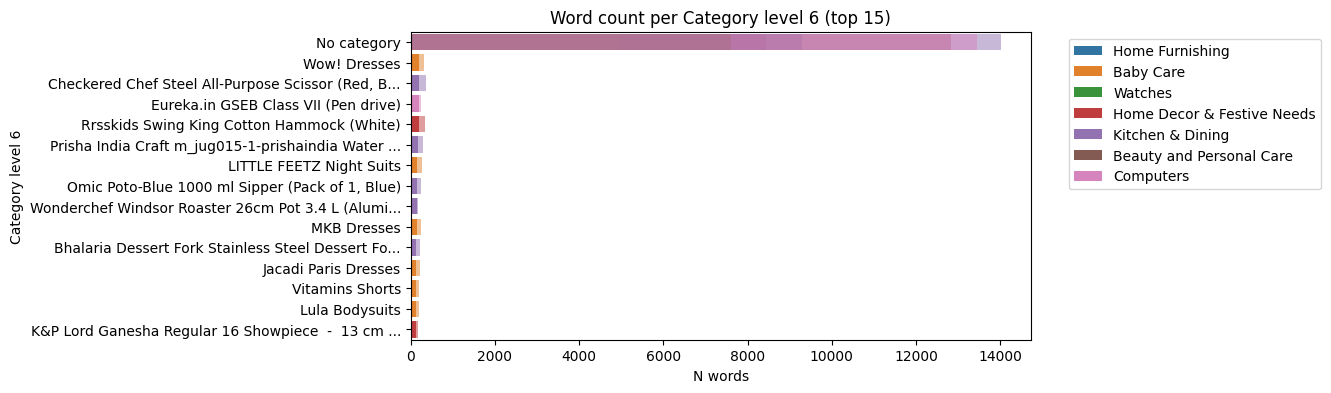

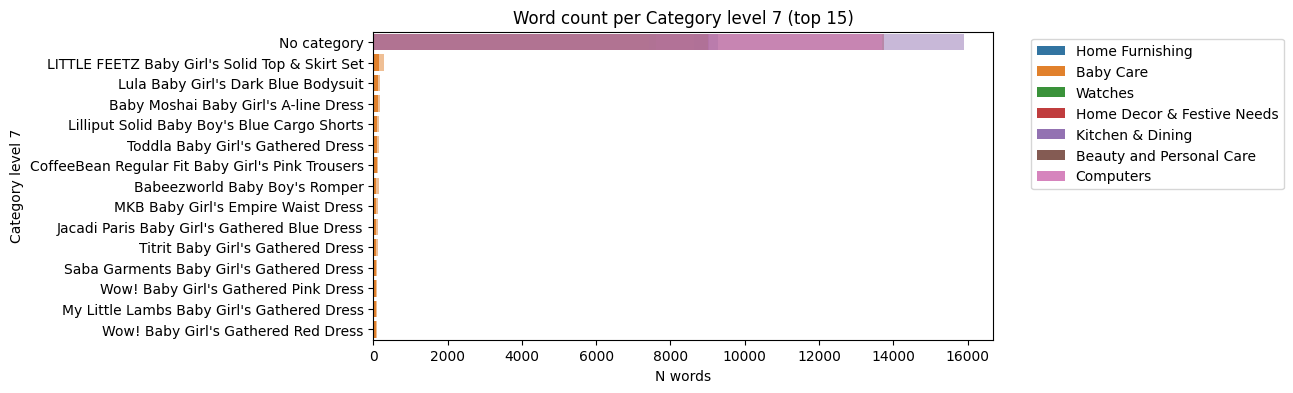

In [171]:
draw_top_categories_all_levels(text_data, criteria="n_words_no_sw", other_criteria="n_words")

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\4264656836.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1.05,1))
C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\4264656836.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1.05,1))


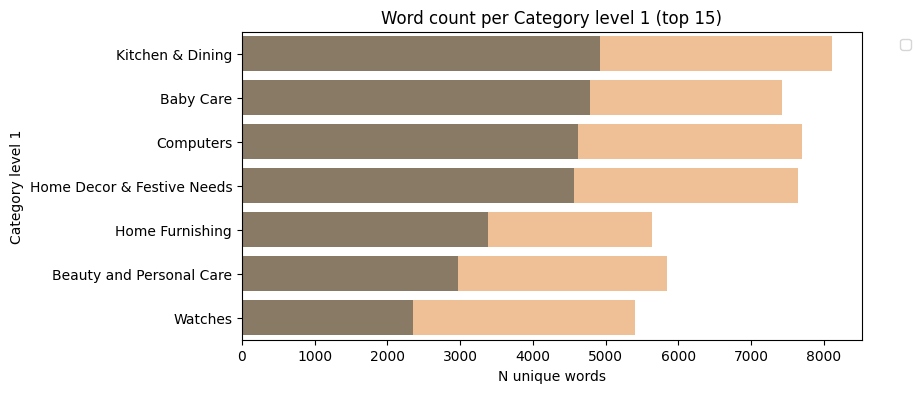

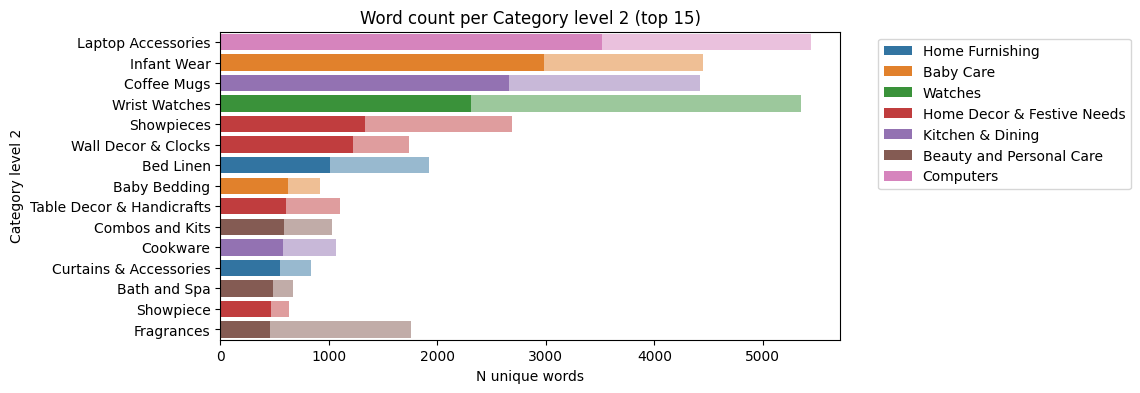

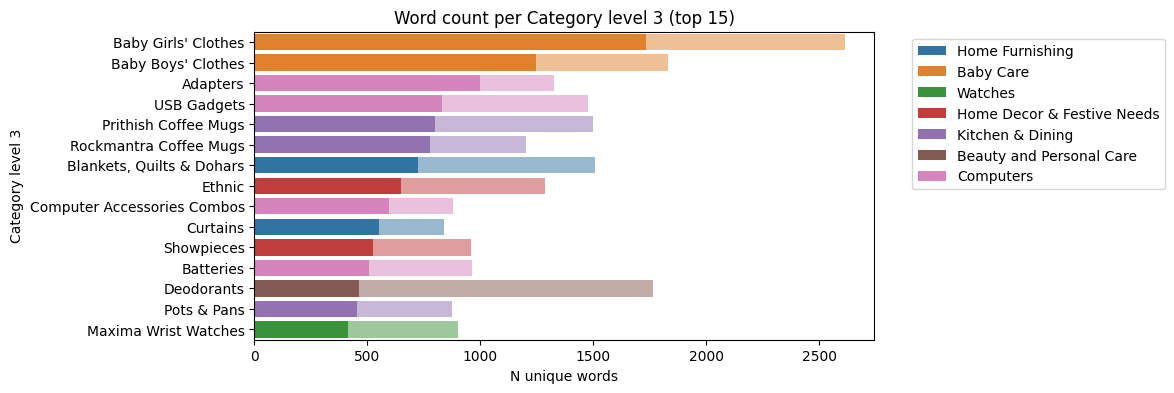

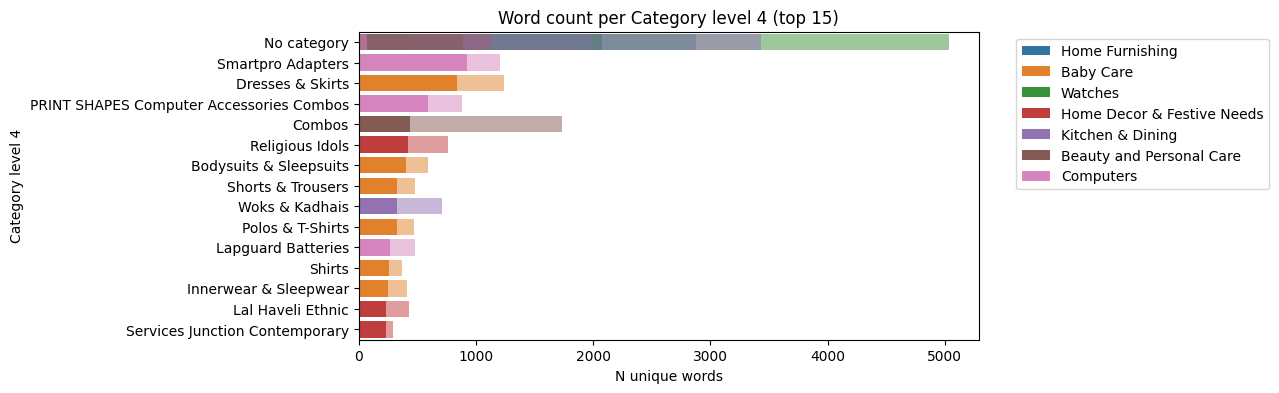

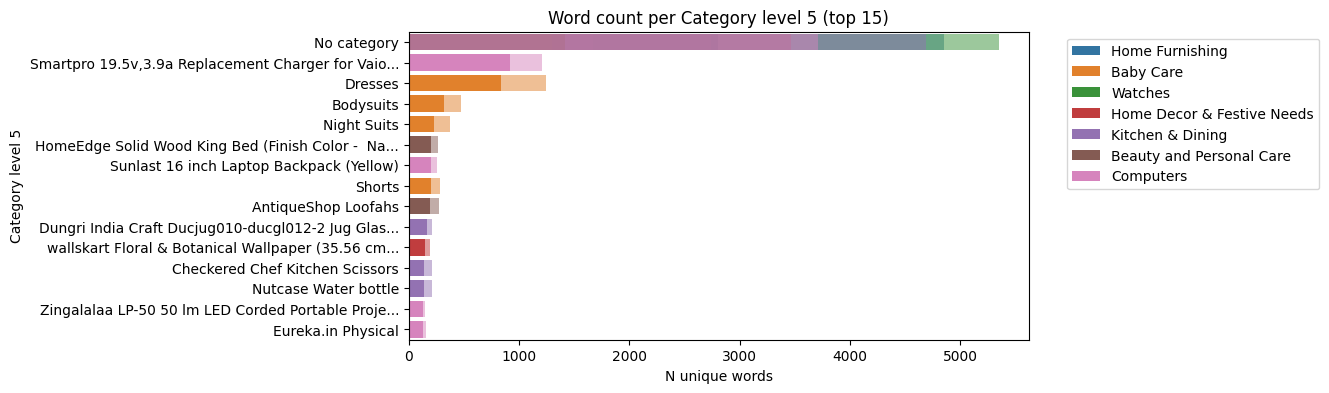

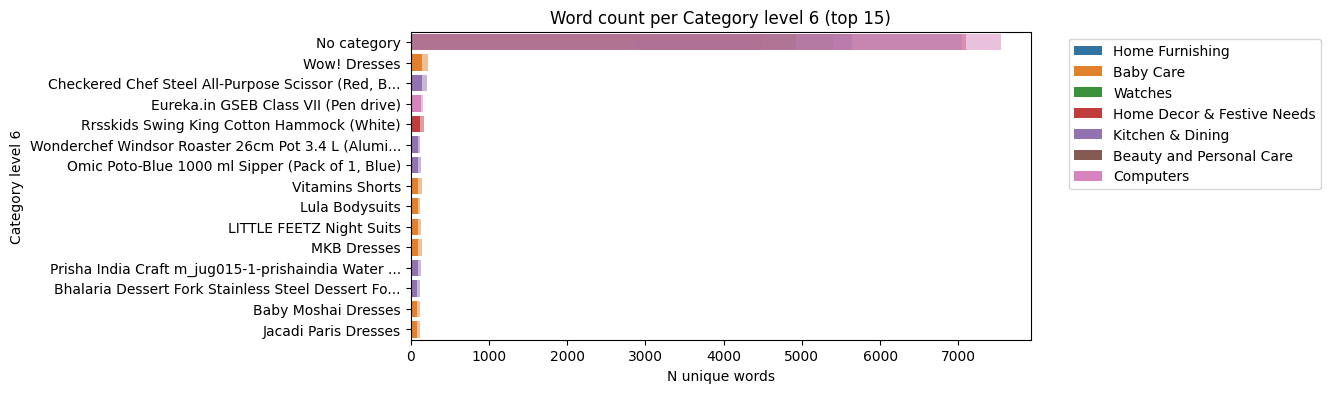

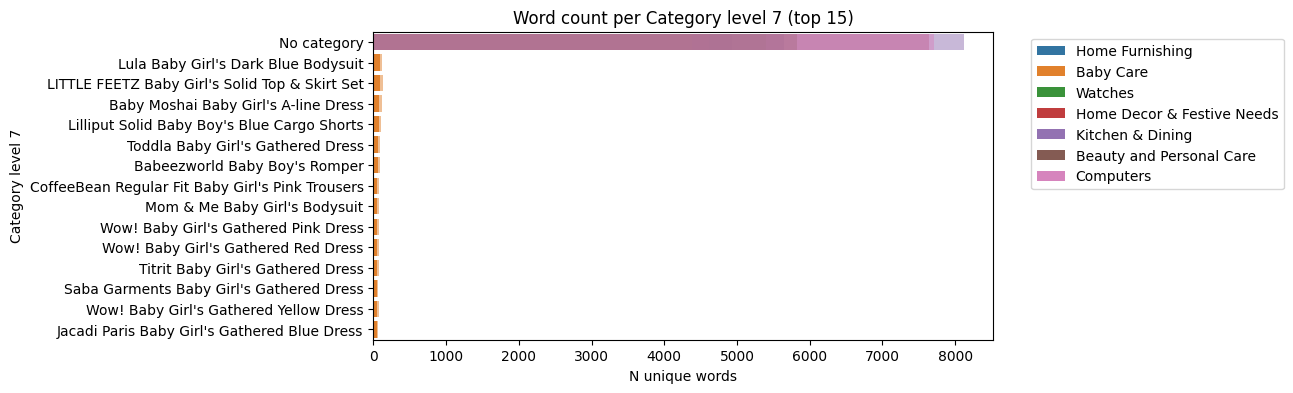

In [172]:
draw_top_categories_all_levels(text_data, criteria="n_unique_words_no_sw", other_criteria="n_unique_words")

## Stemming

In [173]:
def stem_text(text:str, pattern:str=r'\w+'):
	r"""
	Stem text by removing special characters and converting to lowercase.
	
	Parameters:
	text (str): Input text to stem.
	pattern (str): Regular expression pattern to match words. Defaults to r'\w+' which matches word characters.
	
	Returns:
	list: List of stemmed words.
	"""
	ps = PorterStemmer()
	return [ps.stem(word) for word in normalize_text(text, pattern=pattern)]

In [174]:
text_data["tokenized_stem"] = text_data["description"].apply(stem_text)
text_data["n_unique_words_stem"] = text_data["tokenized_stem"].apply(lambda x: len(set(x)))

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\4264656836.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1.05,1))
C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\4264656836.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1.05,1))


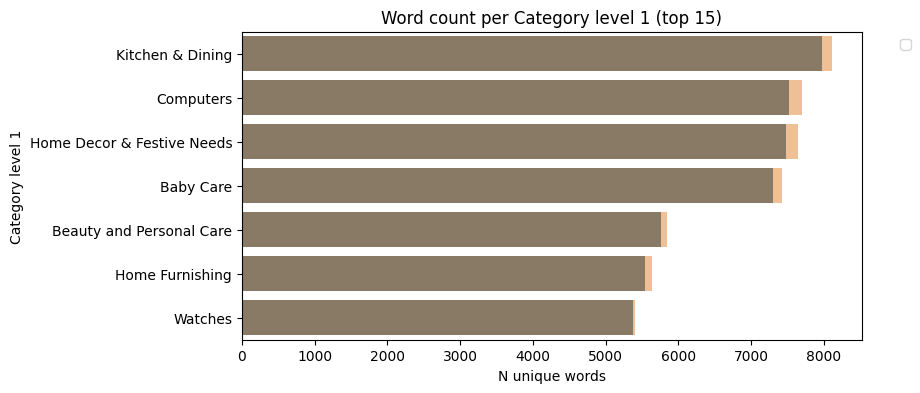

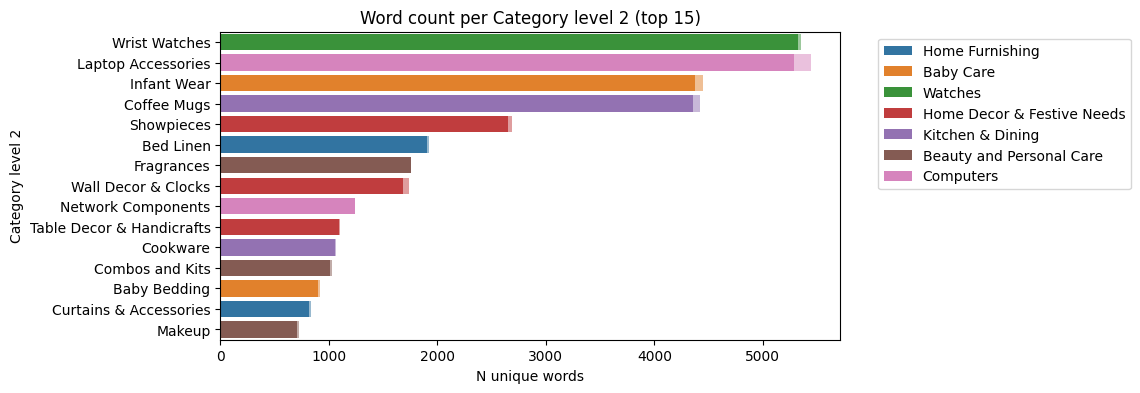

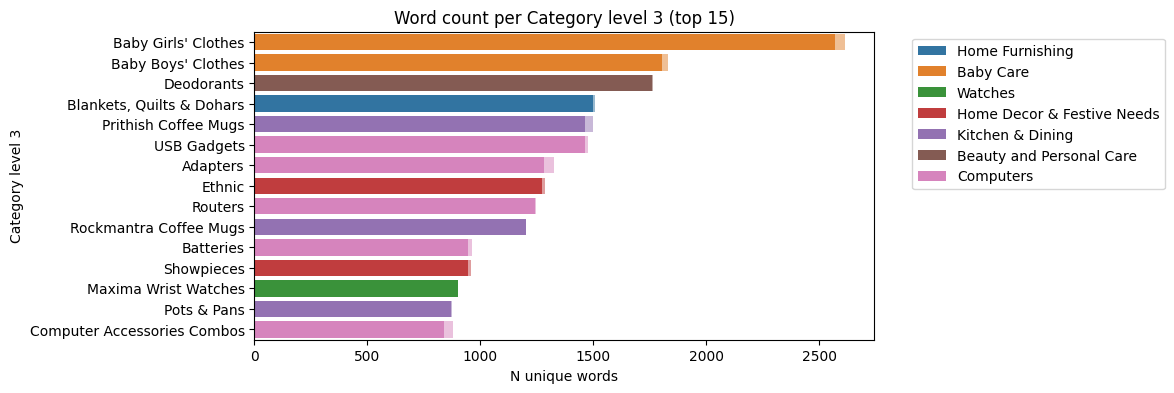

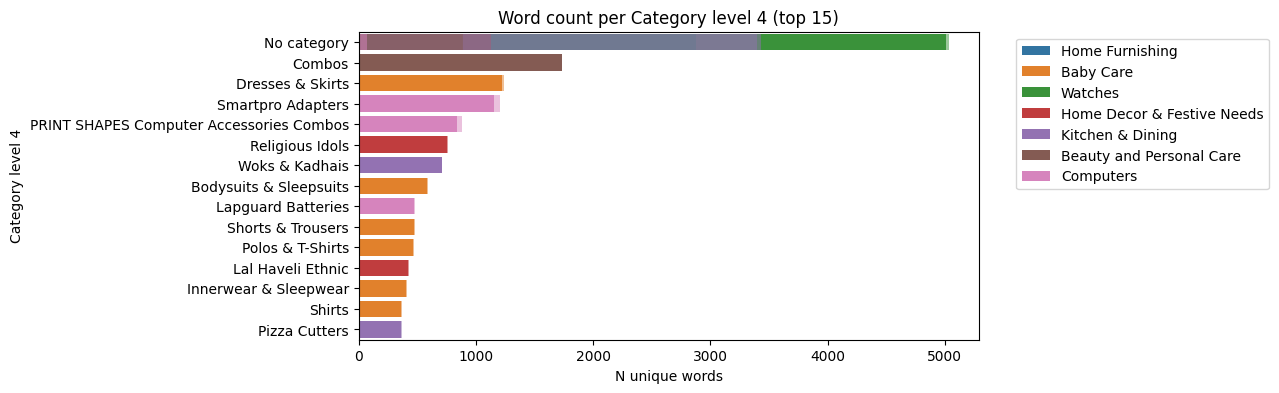

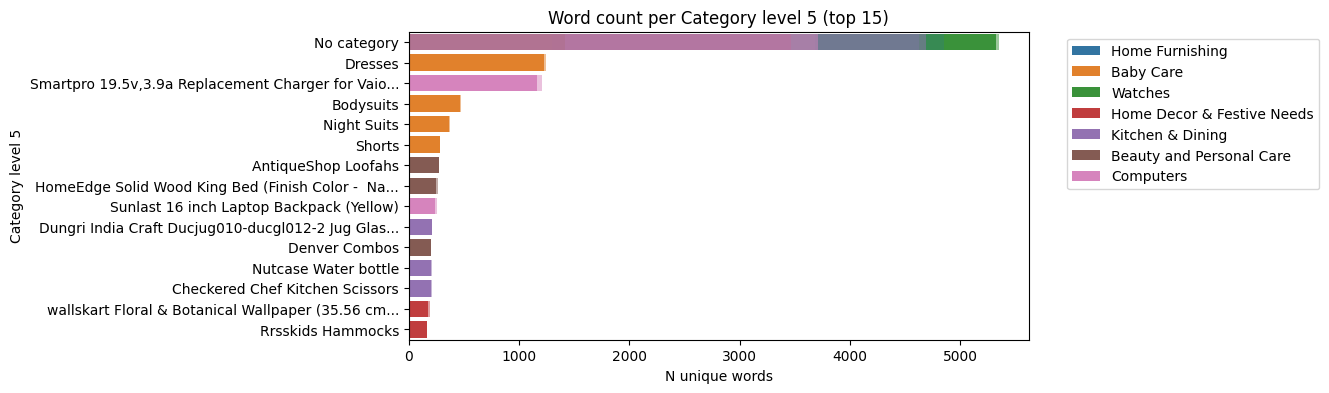

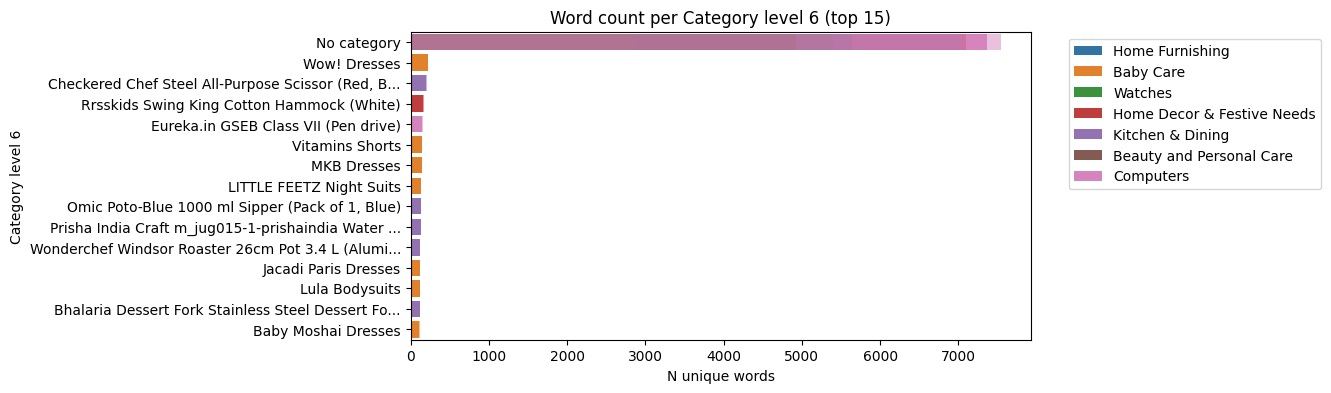

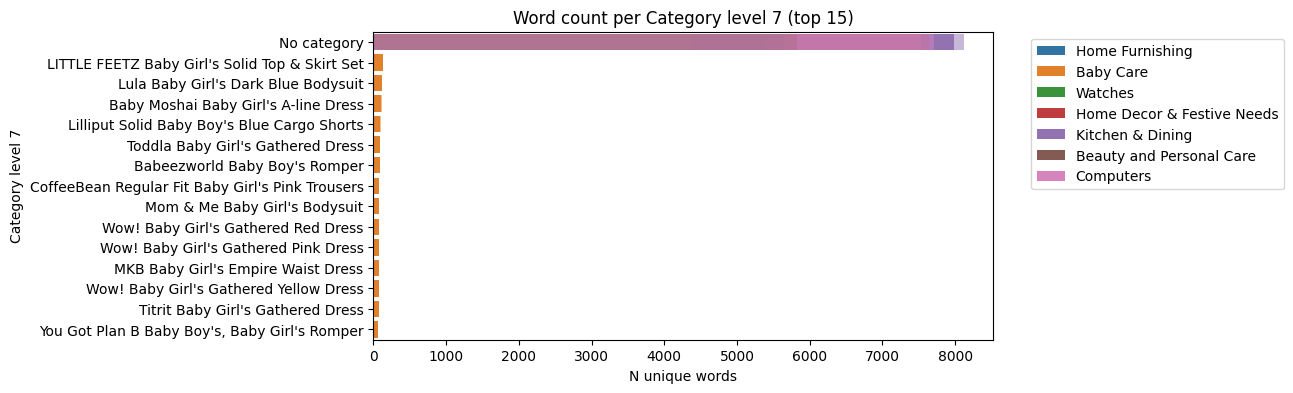

In [175]:
draw_top_categories_all_levels(text_data, criteria="n_unique_words_stem", other_criteria="n_unique_words")

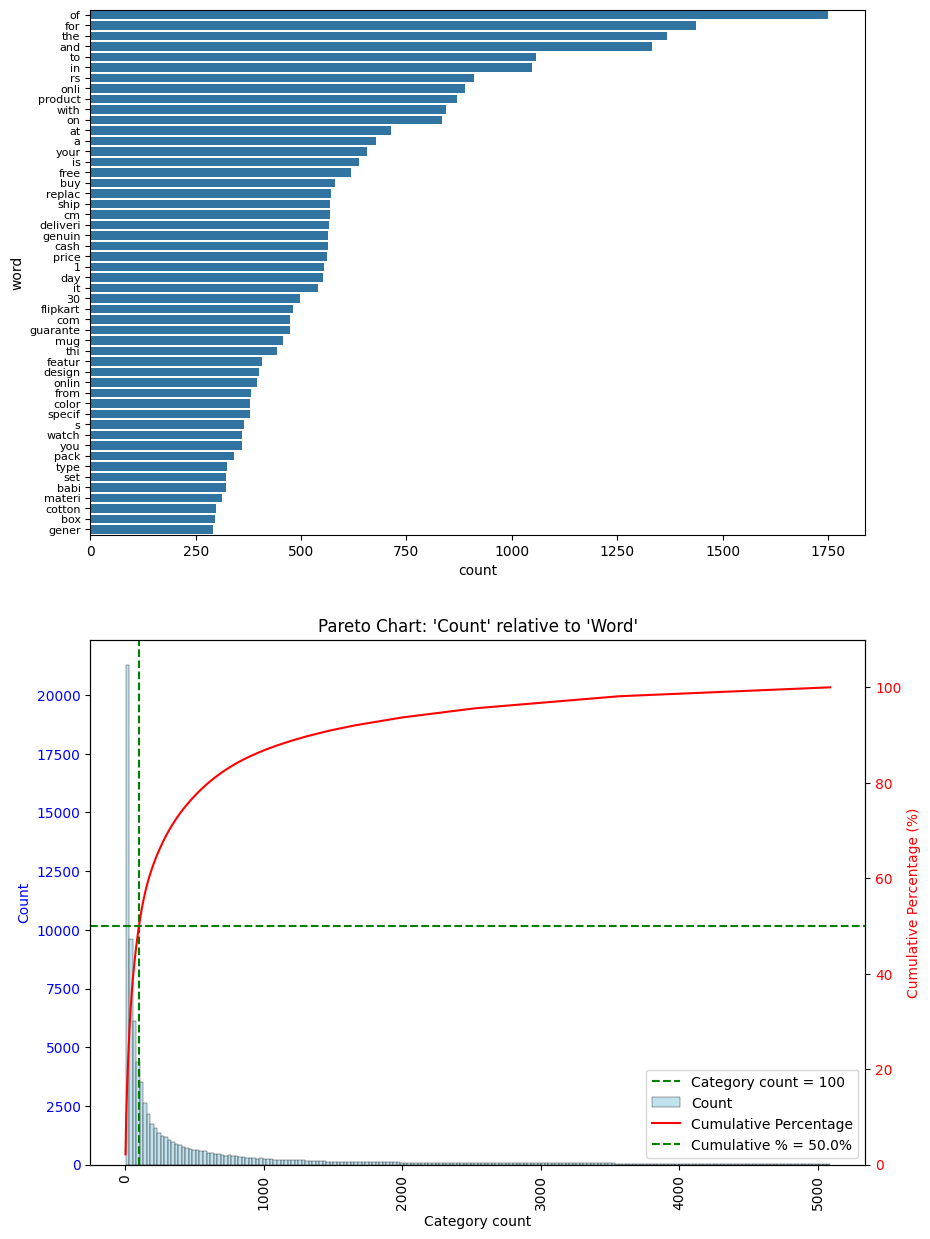

Adding the 100 most common words in the corpus as stopwords. Number of stopwords: 230
Adding the usual stopwords. Number of stopwords: 230


In [176]:
stopwords_stem = get_most_used_words(df=text_data, tokens_col="tokenized_stem", threshold_words=100, bins=200)
print(f"Adding the 100 most common words in the corpus as stopwords. Number of stopwords: {len(stopwords)}")
stopwords_stem.update(tuple(nltk.corpus.stopwords.words('english')))
print(f"Adding the usual stopwords. Number of stopwords: {len(stopwords)}")

In [177]:
def stem_text_remove_stopwords(text:str, pattern:str=r'\w+', stopwords:set=stopwords_stem):
	r"""
	Normalize text by removing special characters, converting to lowercase, and removing stopwords.
	
	Parameters:
	text (str): Input text to normalize.
	pattern (str): Regular expression pattern to match words. Defaults to r'\w+' which matches word characters.
	stopwords (set): Set of stopwords to remove from the text. Defaults to the global stopwords set.
	
	Returns:
	list: List of normalized words without stopwords.
	"""
	return [word for word in stem_text(text, pattern=pattern) if word not in stopwords]

In [178]:
text_data["tokenized_stem_no_sw"] = text_data["description"].apply(stem_text_remove_stopwords)
text_data["n_unique_words_stem_no_sw"] = text_data["tokenized_stem_no_sw"].apply(lambda x: len(set(x)))

In [179]:
example = "Here are other examples of sentences, which were demonstrating stemming and stopword removal. This is how it used to be done."
print(example)
stem_text(example)

Here are other examples of sentences, which were demonstrating stemming and stopword removal. This is how it used to be done.


['here',
 'are',
 'other',
 'exampl',
 'of',
 'sentenc',
 'which',
 'were',
 'demonstr',
 'stem',
 'and',
 'stopword',
 'remov',
 'thi',
 'is',
 'how',
 'it',
 'use',
 'to',
 'be',
 'done']

## Lemmatization

In [180]:
def get_wordnet_pos(tag):
	if tag.startswith('J'):  
		return 'a'
	elif tag.startswith('V'):  
		return 'v'
	elif tag.startswith('N'):  
		return 'n'
	elif tag.startswith('R'):  
		return 'r'
	else:
		return 'n'

In [181]:
def lemmatize_text(text:str, pattern:str=r'\w+'):
	r"""
	Lemmatizes the input text using WordNetLemmatizer.
	
	Parameters:
	text (str): Input text to lemmatize.
	pattern (str): Regular expression pattern to match words. Defaults to r'\w+' which matches word characters.
	
	Returns:
	list: List of lemmatized words.
	"""
		
	tokens = normalize_text(text, pattern=pattern)
	tagged_tokens = nltk.pos_tag(tokens) # POS tagging to improve lemmatization
	
	lemmatizer = WordNetLemmatizer()
	return [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_tokens]

In [182]:
text_data["tokenized_lemma"] = text_data["description"].apply(lemmatize_text)
text_data["n_unique_words_lemma"] = text_data["tokenized_lemma"].apply(lambda x: len(set(x)))

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\4264656836.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1.05,1))
C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\4264656836.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1.05,1))


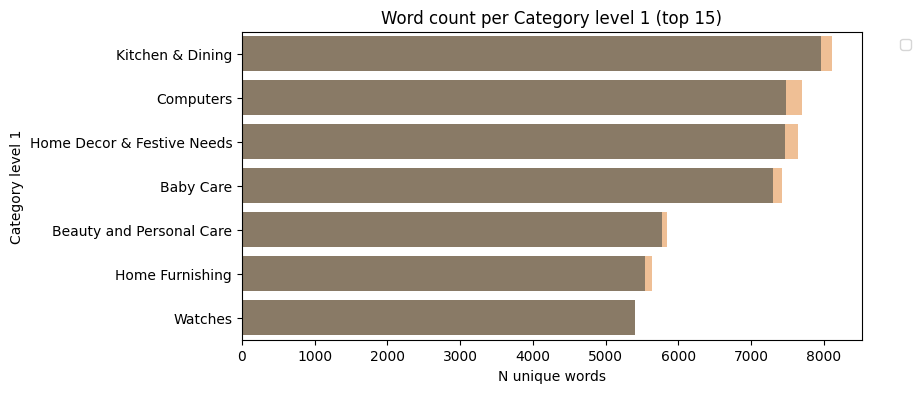

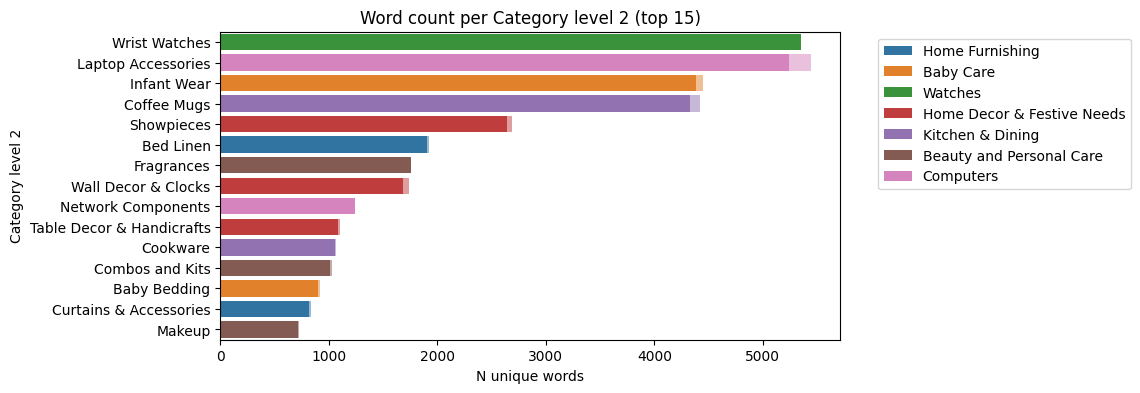

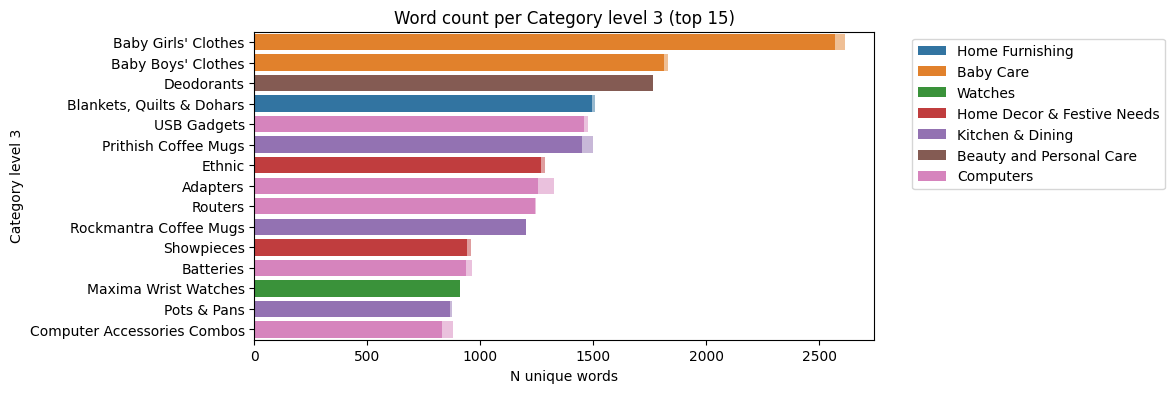

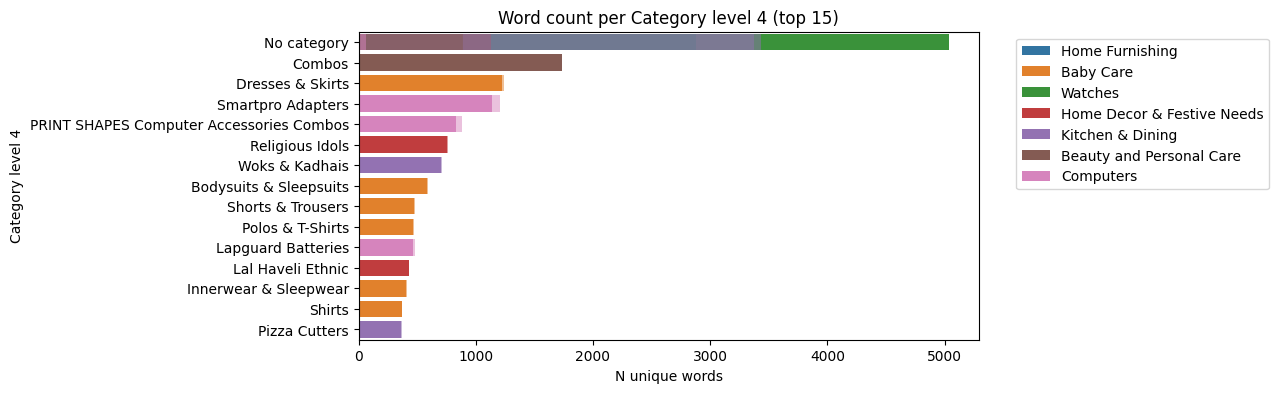

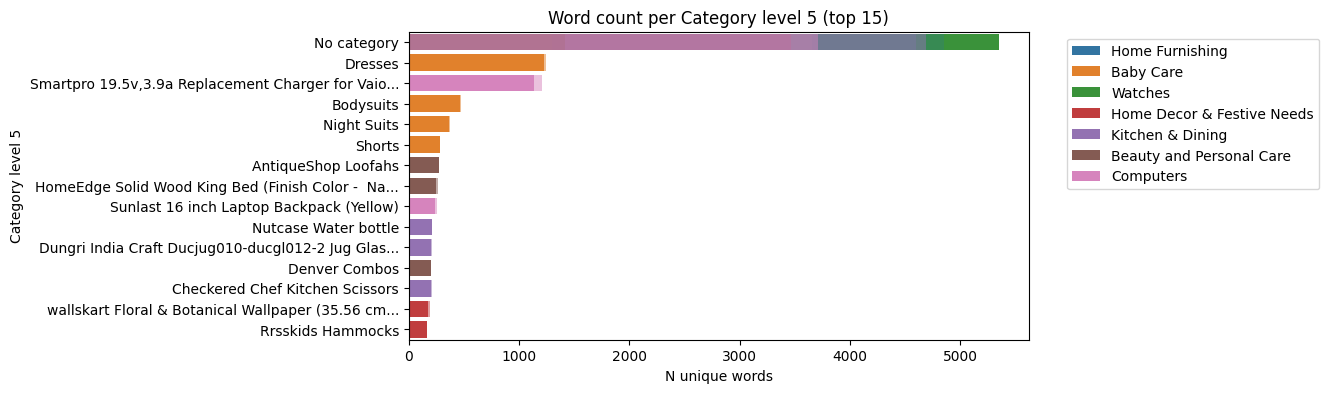

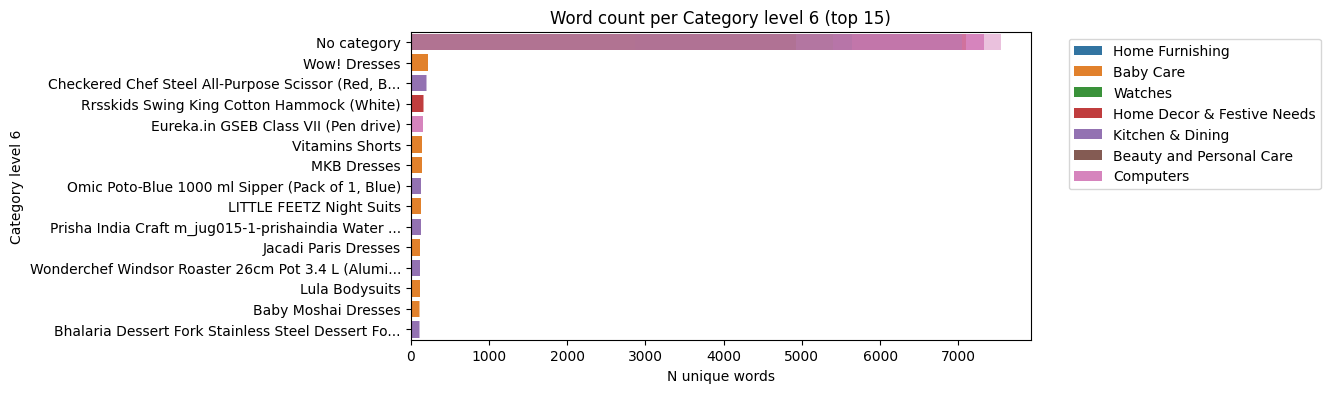

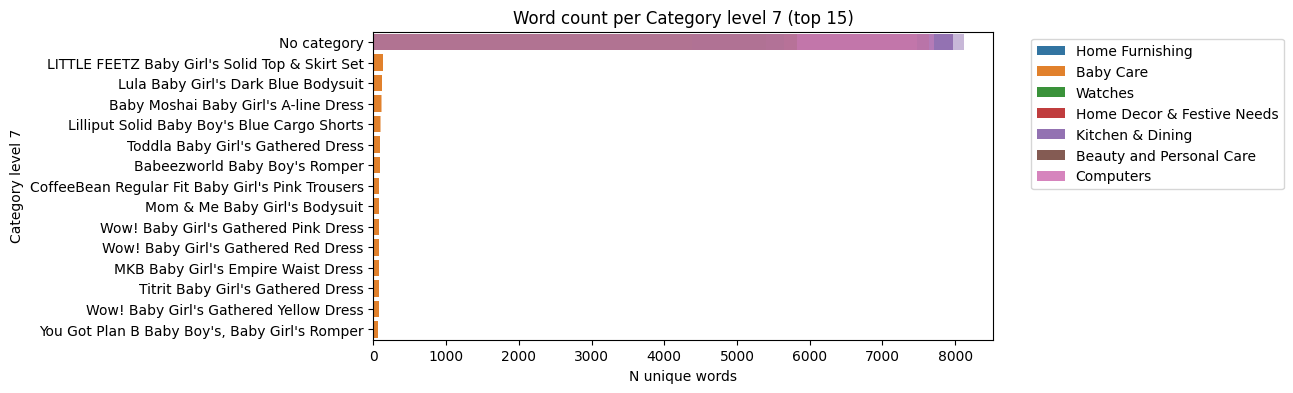

In [183]:
draw_top_categories_all_levels(text_data, criteria="n_unique_words_lemma", other_criteria="n_unique_words")

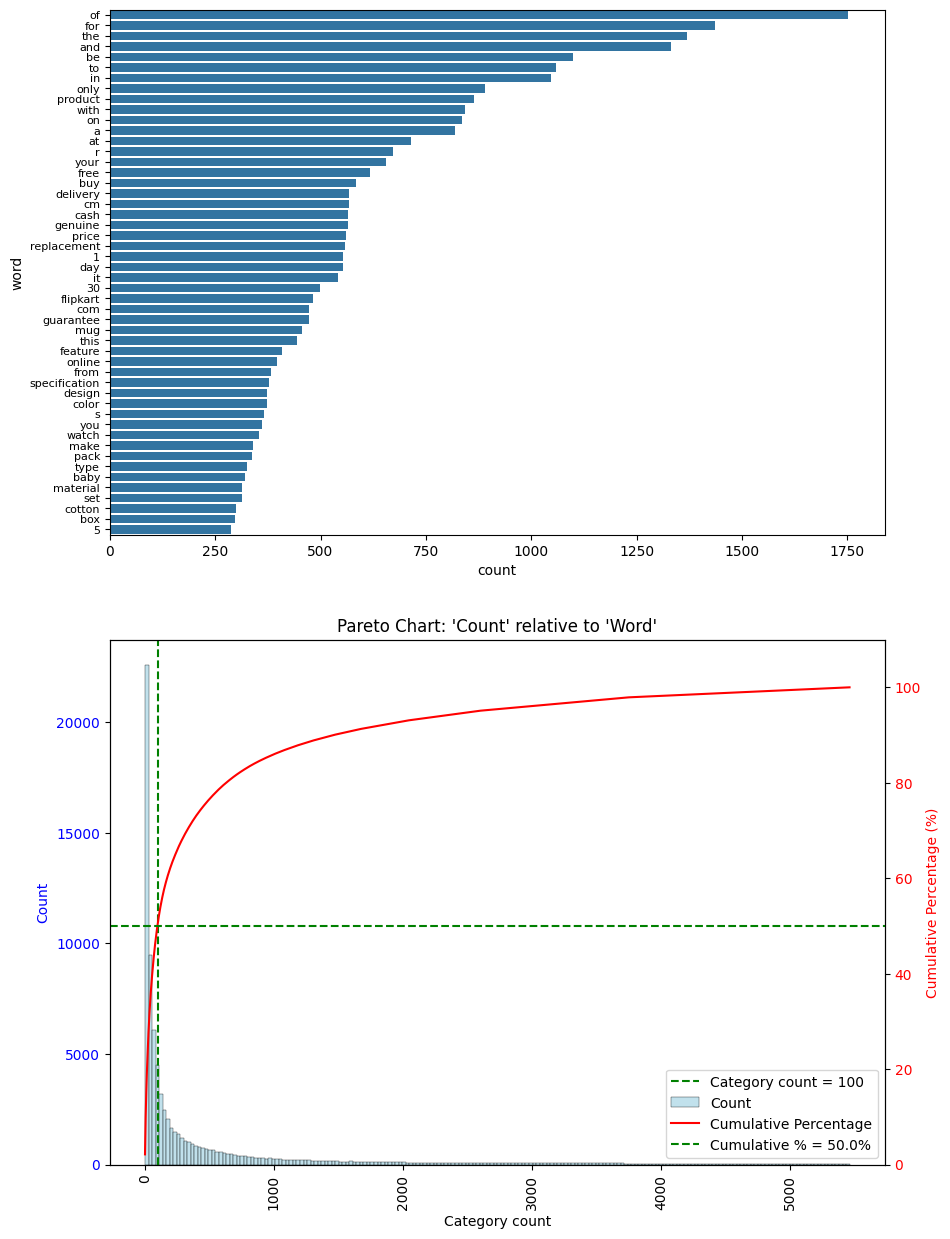

Adding the 100 most common words in the corpus as stopwords. Number of stopwords: 230
Adding the usual stopwords. Number of stopwords: 230


In [184]:
stopwords_lemma = get_most_used_words(df=text_data, tokens_col="tokenized_lemma", threshold_words=100, bins=200)
print(f"Adding the 100 most common words in the corpus as stopwords. Number of stopwords: {len(stopwords)}")
stopwords_lemma.update(tuple(nltk.corpus.stopwords.words('english')))
print(f"Adding the usual stopwords. Number of stopwords: {len(stopwords)}")

In [185]:
def lemmatize_text_remove_stopwords(text:str, pattern:str=r'\w+', stopwords:set=stopwords_lemma):
	r"""
	Normalize text by removing special characters, converting to lowercase, and removing stopwords.
	
	Parameters:
	text (str): Input text to normalize.
	pattern (str): Regular expression pattern to match words. Defaults to r'\w+' which matches word characters.
	stopwords (set): Set of stopwords to remove from the text. Defaults to the global stopwords set.
	
	Returns:
	list: List of normalized words without stopwords.
	"""
	return [word for word in lemmatize_text(text) if word not in stopwords]

In [186]:
text_data["tokenized_lemma_no_sw"] = text_data["description"].apply(lemmatize_text_remove_stopwords)
text_data["n_unique_words_lemma_no_sw"] = text_data["tokenized_lemma_no_sw"].apply(lambda x: len(set(x)))

In [187]:
example = "Here are other examples of sentences, which were demonstrating stemming and stopword removal. This is how it used to be done."
print(example)
lemmatize_text(example)

Here are other examples of sentences, which were demonstrating stemming and stopword removal. This is how it used to be done.


['here',
 'be',
 'other',
 'example',
 'of',
 'sentence',
 'which',
 'be',
 'demonstrate',
 'stem',
 'and',
 'stopword',
 'removal',
 'this',
 'be',
 'how',
 'it',
 'use',
 'to',
 'be',
 'do']

Visualiser la distribution des fonctions grammaticales

In [188]:
text_data["simplified_pos_tagging"] = text_data["tokenized"].apply(lambda w: [tag for word, tag in nltk.pos_tag(w, "universal")])
# text_data["simplified_pos_tagging"] = text_data["pos_tagging"].apply(get_wordnet_pos)
text_data

uniq_id     crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7 2016-04-30 03:22:56   
1     7b72c92c2f6c40268628ec5f14c6d590 2016-04-30 03:22:56   
2     64d5d4a258243731dc7bbb1eef49ad74 2016-04-30 03:22:56   
3     d4684dcdc759dd9cdf41504698d737d8 2016-06-20 08:49:52   
4     6325b6870c54cd47be6ebfbffa620ec7 2016-06-20 08:49:52   
...                                ...                 ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc 2015-12-01 10:15:43   
1046  fd6cbcc22efb6b761bd564c28928483c 2015-12-01 10:15:43   
1047  5912e037d12774bb73a2048f35a00009 2015-12-01 10:15:43   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6 2015-12-01 10:15:43   
1049  f2f027ad6a6df617c9f125173da71e44 2015-12-01 10:15:43   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049        1190.0             595.0  f2f027ad6a6df617c9f125173da71e44.jpg   

      

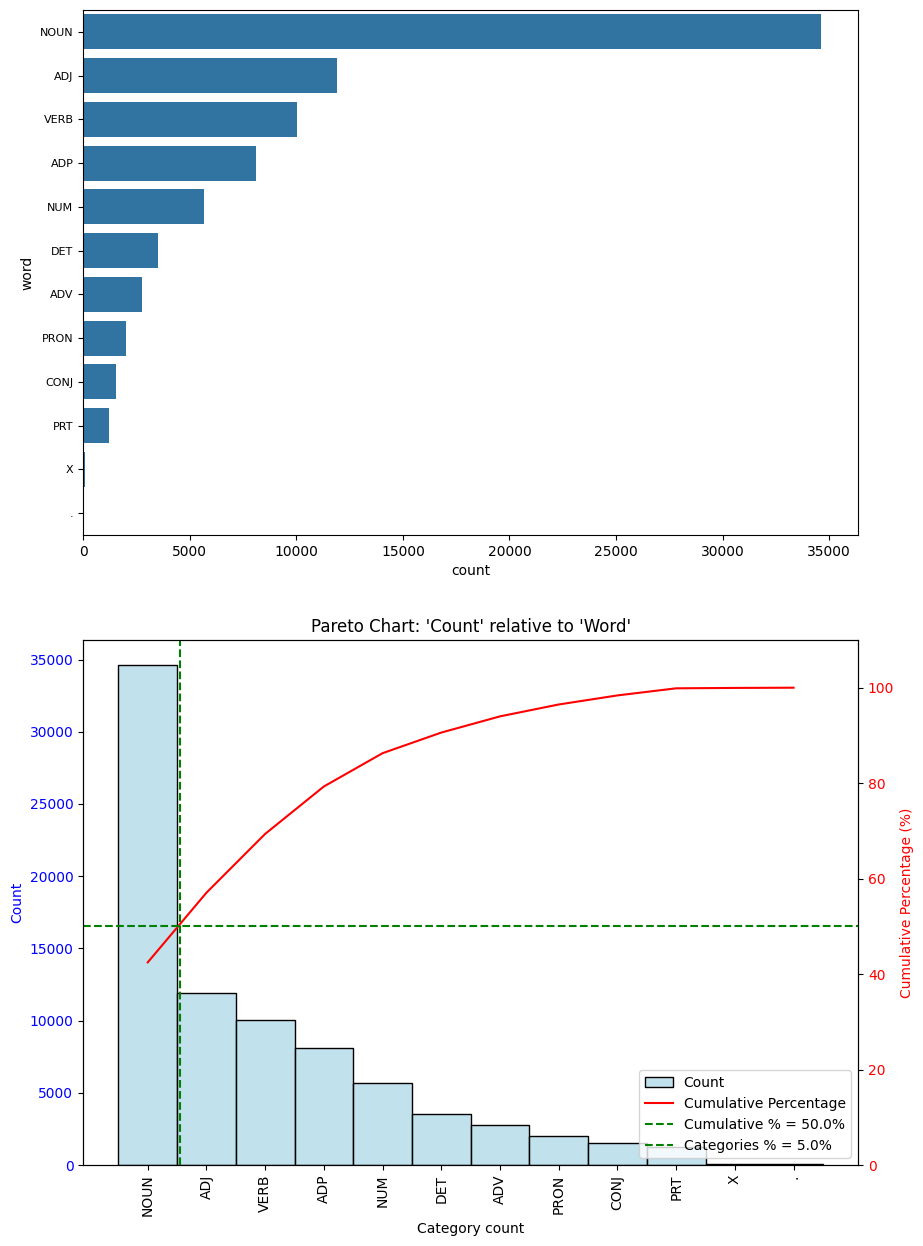

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [189]:
get_most_used_words(df=text_data, tokens_col="simplified_pos_tagging")

## TF-IDF

In [ ]:
class Model():
    """
    A machine learning model wrapper for cross-validation, evaluation, and comparison.
    
    This class provides a comprehensive framework for training, evaluating, and comparing
    machine learning models using cross-validation. It handles data splitting, model
    training, result visualization, and performance comparison across different pipelines.
    
    Attributes
    ----------
    project_name : str
        Name of the project for organizing model results.
    model_results_path : str
        Path where model results are stored.
    """
    
    project_name = 'text-based_classification'
    model_results_path = os.path.join('utils', 'model_results', project_name)

    def __init__(self,
            df: pd.DataFrame,
            target: list[str] | str,
            estimator,
            cv: KFold,
            train_test_ratio: float = 0.75,
            features: list[str] = None,
            items_to_display: list[Literal["all", "folds", "split", "conf_mat", "feature_importance"]] = ["all"],
            scores: dict = {'r2': make_scorer(r2_score), 'Precision': make_scorer(precision_score)}, 
            random_state = RANDOM_STATE
            ):
        """
        Initialize the Model with data, estimator, and evaluation parameters.
        
        Parameters
        ----------
        df : pd.DataFrame
            The input dataset containing features and target variables.
        target : list[str] | str
            Target column name(s). If list, columns will be concatenated.
        estimator : sklearn estimator
            The machine learning estimator/pipeline to evaluate.
        cv : KFold
            Cross-validation strategy object.
        train_test_ratio : float, default=0.75
            Proportion of data to use for training (0.0 to 1.0).
        features : list[str], optional
            List of feature column names. If None, uses all columns except target.
        items_to_display : list, default=["all"]
            Controls which visualizations to display. Options: "all", "folds", 
            "split", "conf_mat", "feature_importance".
        scores : dict, default={'r2': make_scorer(r2_score), 'Precision': make_scorer(precision_score)}
            Dictionary of scoring metrics for cross-validation.
        random_state : int
            Random state for reproducible results.
        """
        df_copy = df.copy()
        if isinstance(target, list):
            df_copy["target"] = df_copy[target].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)
            target = "target"
        self.target = target
        self.estimator = estimator
        self.scores = scores
        self.cv = cv
        self.random_state = random_state
        self.display_split = "split" in items_to_display or "all" in items_to_display
        self.display_folds = "folds" in items_to_display or "all" in items_to_display
        self.display_confusion_matrix = "conf_mat" in items_to_display or "all" in items_to_display
        self.display_feature_importance = "feature_importance" in items_to_display or "all" in items_to_display
        self.display_scores = "all" in items_to_display or "scores" in items_to_display
        self.display_metrics = "all" in items_to_display or "metrics" in items_to_display
        self.display_other_projects = "all" in items_to_display or "other_projects" in items_to_display
        df_copy = self.remove_too_few_categories(df=df_copy)
        self.splitting(df=df_copy, features=features, train_test_ratio=train_test_ratio)

    def splitting(self, df: pd.DataFrame, features: list[str], train_test_ratio: float = 0.75):
        """
        Split the dataset into training and testing sets.
        
        Performs stratified train-test split and prepares feature matrices and target vectors.
        Optionally displays the distribution of the split.
        
        Parameters
        ----------
        df : pd.DataFrame
            The dataset to split.
        features : list[str]
            List of feature column names to use.
        train_test_ratio : float, default=0.75
            Proportion of data to use for training.
        """
        if features is not None: # Keep all features if features is None
            df = df[features + [self.target]]
        self.df_train, self.df_test = train_test_split(df, train_size=train_test_ratio, random_state=self.random_state, stratify=df[self.target])
        self.X_train, self.y_train = self.df_train[features], self.df_train[self.target]
        self.X_test, self.y_test = self.df_test[features], self.df_test[self.target]

        if self.display_split:
            self.plot_split(df=df, train=self.df_train, train_test_ratio=train_test_ratio, title="Train / Test split distribution relative to target")

    def remove_too_few_categories(self, df: pd.DataFrame):
        """
        Remove target categories with insufficient samples for cross-validation.
        
        Categories with fewer samples than the number of CV folds are removed
        to prevent errors during stratified cross-validation.
        
        Parameters
        ----------
        df : pd.DataFrame
            The input dataset.
            
        Returns
        -------
        pd.DataFrame
            Dataset with rare categories removed.
        """
        threshold = self.cv.get_n_splits()
        value_counts = text_data[self.target].value_counts()
        rarest_categories = value_counts.loc[value_counts.values < threshold].index.values
        if len(rarest_categories) > 0:
            print(f"Removing these categories which contain too few elements :\n{'\n'.join([f'- {cat} ({value})' for cat, value in value_counts.items() if cat in rarest_categories])}")
        return df.loc[~df[self.target].isin(rarest_categories)]
    
    class NpEncoder(json.JSONEncoder):
        """
        Custom JSON encoder for handling NumPy types and other non-serializable objects.
        
        Extends json.JSONEncoder to handle NumPy generic types, Python types,
        and function objects that are commonly found in sklearn estimator parameters.
        """
        
        def default(self, obj):
            """
            Convert non-serializable objects to JSON-serializable format.
            
            Parameters
            ----------
            obj : any
                Object to encode.
                
            Returns
            -------
            any
                JSON-serializable representation of the object.
            """
            if isinstance(obj, np.generic):
                return obj.item()
            elif isinstance(obj, type):
                return str(obj)
            elif isinstance(obj, FunctionType):
                return obj.__name__
            return super().default(obj)

    def encode_inst_args(self, est):
        """
        Generate a unique hash for an estimator based on its parameters.
        
        Creates a short hash string representing the estimator's configuration,
        useful for creating unique identifiers for different model configurations.
        
        Parameters
        ----------
        est : sklearn estimator
            The estimator to encode.
            
        Returns
        -------
        str
            8-character hash representing the estimator's parameters.
        """
        try:
            params = est.get_params()
        except:
            params = est.__dict__
        param_str = json.dumps(params, cls=self.NpEncoder, sort_keys=True)
        return hashlib.md5(param_str.encode()).hexdigest()[:8]  
    
    def get_pipeline_name(self, estimator):
        """
        Generate a descriptive name for a pipeline or estimator.
        
        Creates a unique name based on the estimator class names and their
        parameter configurations. Handles both Pipeline objects and single estimators.
        
        Parameters
        ----------
        estimator : sklearn estimator or Pipeline
            The estimator or pipeline to name.
            
        Returns
        -------
        str
            Unique name for the pipeline/estimator.
        """
        if isinstance(estimator, Pipeline):
            steps = estimator.named_steps
            name_parts = [f"{est.__class__.__name__}-{self.encode_inst_args(est)}" for  est in steps.values()]
            pipeline_name = "_".join(name_parts)
        else:
            pipeline_name = f"{estimator.__class__.__name__}_{self.encode_inst_args(estimator)}"
        return pipeline_name
    
    def _prepare_X(self, X: pd.DataFrame | pd.Series):
        """
        Prepare feature matrix for sklearn compatibility.
        
        Ensures the feature matrix is in the correct format:
        - Single feature: returns 1D array/Series
        - Multiple features: returns 2D DataFrame/array
        
        Parameters
        ----------
        X : pd.DataFrame | pd.Series
            Feature matrix to prepare.
            
        Returns
        -------
        pd.DataFrame | pd.Series
            Properly formatted feature matrix.
        """
        if isinstance(X, pd.DataFrame) and X.shape[1] == 1:
            # Flatten to 1D
            return X.squeeze()
        return X
    
    def run(self, force_compute: bool = False):
        """
        Execute cross-validation and display results.
        
        Performs cross-validation on the estimator, saves/loads results,
        and displays various performance visualizations and comparisons.
        
        Parameters
        ----------
        force_compute : bool, default=False
            If True, forces recomputation even if cached results exist.
        """
        if self.display_folds:
            n_folds = self.cv.get_n_splits()
            train_test_ratio_cv = 1-1/n_folds
            n_cols = min(2, n_folds) 
            n_rows = math.ceil(n_folds / n_cols)
            fig, axes = plt.subplots(n_rows, n_cols, figsize = (n_cols*6, n_rows*4))
            axes = axes.flatten()
            for fold_idx, (train_idx, test_idx) in enumerate(self.cv.split(self.X_train, self.y_train)):
                self.plot_split(df=self.df_train, train=self.df_train.iloc[train_idx], train_test_ratio=train_test_ratio_cv, title=f"Fold {fold_idx+1}", ax=axes[fold_idx])
            fig.suptitle("Train / Test split distribution per quantile of target")
            fig.tight_layout()
            plt.show()
        
        self.pipeline_name = self.get_pipeline_name(self.estimator)
        filename = os.path.join(Model.model_results_path, f"{self.pipeline_name}.pkl")
        if os.path.exists(filename) and not force_compute: # if model was already fitted, and cross validation was already performed for this dataframe (identified by the 'project_name' argument) and for this pipeline, do not compute again, just load the saved pickle object.
            with open(filename, 'rb') as f:
                self.pipeline_result = pickle.load(f)
            print(f"Cross validation results for pipeline '{self.pipeline_name}' was retrieved from {filename}.")
        else:
            X = self._prepare_X(self.X_train)
            y = self._prepare_X(self.y_train)
            with EmissionsTracker(project_name=Model.project_name, experiment_id=self.pipeline_name, tracking_mode="process", log_level='CRITICAL') as tracker:  
                cv_model = cross_validate(estimator=self.estimator, X=X, y=y, cv=self.cv, scoring=self.scores, return_train_score=True, return_estimator=True, n_jobs=self.cv.get_n_splits(), error_score='raise')
                cv_model = pd.DataFrame(cv_model)
                cv_model['co2_emissions'] = tracker.flush()
            self.pipeline_result = pd.concat({self.pipeline_name: cv_model}, names=['Pipeline', 'Split']) # Add an index level
            with open(filename, 'wb') as f:
                pickle.dump(self.pipeline_result, f)
        self.display_comparison()

    def display_comparison(self):
        """
        Load and display comparison results across all saved pipelines.
        
        Loads results from all previously computed pipelines and displays
        score and metric comparisons if requested.
        
        Returns
        -------
        pd.DataFrame
            Combined results from all pipelines for comparison.
        """
        comparison_results = pd.DataFrame()
        pathlist = Path(Model.model_results_path).glob('**/*.pkl')
        for path in pathlist:
            with open(path, 'rb') as f:
                pipeline_result = pickle.load(f)
            comparison_results = pd.concat([comparison_results, pipeline_result], axis=0) # Concatenate with global dataframe
        
        comparison_results = comparison_results.reset_index().sort_values(by=["Pipeline"])
        if self.display_scores:
            self.plot_score_comparison(comparison_results=comparison_results)
        if self.display_metrics:
            self.plot_metric_comparison(comparison_results=comparison_results)

        return comparison_results
    
    def plot_split(self, df: pd.DataFrame, train: pd.DataFrame, train_test_ratio: float, title: str = "", ax=None):
        """
        Visualize the distribution of target classes in train/test splits.
        
        Creates a horizontal histogram showing the proportion of each target class
        in the training and testing sets.
        
        Parameters
        ----------
        df : pd.DataFrame
            Complete dataset.
        train : pd.DataFrame
            Training subset.
        train_test_ratio : float
            Expected training ratio for reference line.
        title : str, default=""
            Plot title.
        ax : matplotlib.axes.Axes, optional
            Axes object to plot on. If None, creates new figure.
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(7, 7), sharex=True)
        hue = ["train" if i in train.index else "test" for i in df.index]
        sns.histplot(data=df, y=self.target, hue=hue, ax=ax, discrete=True, multiple="fill", hue_order=["train", "test"])
        ax.set_ylabel("Target")
        ax.set_xlabel("Proportion of individuals in train and test splits")
        ax.axvline(1-train_test_ratio, color='red', linestyle='--')
        ax.annotate(
            f"Ideal distribution",
            xy=(0.97-train_test_ratio, -0.05),
            xycoords="axes fraction",
            color='r',
        )
        ax.set_title(title, fontsize=12)

    def plot_score_comparison(self, comparison_results: pd.DataFrame):
        """
        Create box plots comparing train and test scores across pipelines.
        
        For each scoring metric, creates side-by-side box plots showing
        the distribution of train and test scores across cross-validation folds.
        
        Parameters
        ----------
        comparison_results : pd.DataFrame
            Combined results from multiple pipelines.
        """
        # Reshape the DataFrame for scores to be able to use hue for train vs test scores
        for score in self.scores:
            # Extract train and test scores for each score
            train_score_col = f'train_{score}'
            test_score_col = f'test_{score}'

            # Create a new DataFrame for the current score
            score_data = comparison_results[['Pipeline', train_score_col, test_score_col]].melt(id_vars=['Pipeline'], value_vars=[train_score_col, test_score_col], 
                                                                                                var_name='Type', value_name=score)
            
            score_data['Type'] = score_data['Type'].apply(lambda x: 'Train' if 'train' in x else 'Test')


In [ ]:
class TextClassifier(Model):
    """
    A specialized text classification model that extends the base Model class.
    
    This class provides text-specific functionality for classification tasks,
    including text vectorization, pipeline creation, and feature importance
    visualization for text data. It automatically creates a pipeline with
    a text vectorizer and classifier.
    
    Inherits from Model and adds text-specific methods for feature analysis
    and visualization of word importance across different classes.
    """
    
    def __init__(self, 
                df: pd.DataFrame,
                target: list[str] | str,
                cv: KFold,
                vect=TfidfVectorizer(tokenizer=lemmatize_text, stop_words=list(stopwords_lemma)),
                clf=RidgeClassifier(tol=1e-2, solver="sparse_cg"),
                train_test_ratio: float = 0.75,
                features: list[str] = None,
                items_to_display: list[Literal["all", "folds", "split", "conf_mat", "feature_importance"]] = ["all"],
                scores: dict = {'Accuracy': make_scorer(accuracy_score)},
                random_state=RANDOM_STATE):
        """
        Initialize the TextClassifier with text-specific components.
        
        Creates a text classification pipeline by combining a vectorizer and classifier.
        The vectorizer transforms text data into numerical features, and the classifier
        performs the actual classification task.
        
        Parameters
        ----------
        df : pd.DataFrame
            The input dataset containing text features and target variables.
        target : list[str] | str
            Target column name(s). If list, columns will be concatenated.
        cv : KFold
            Cross-validation strategy object.
        vect : sklearn vectorizer, default=TfidfVectorizer(tokenizer=lemmatize_text, stop_words=list(stopwords_lemma))
            Text vectorizer to transform text into numerical features.
            Default uses TF-IDF with lemmatization and stopword removal.
        clf : sklearn classifier, default=RidgeClassifier(tol=1e-2, solver="sparse_cg")
            Classification algorithm to use. Default is Ridge classifier
            optimized for sparse text data.
        train_test_ratio : float, default=0.75
            Proportion of data to use for training (0.0 to 1.0).
        features : list[str], optional
            List of feature column names. If None, uses all columns except target.
        items_to_display : list, default=["all"]
            Controls which visualizations to display. Options: "all", "folds", 
            "split", "conf_mat", "feature_importance".
        scores : dict, default={'Accuracy': make_scorer(accuracy_score)}
            Dictionary of scoring metrics for cross-validation.
            Default uses accuracy which is appropriate for classification.
        random_state : int
            Random state for reproducible results.
        """
        self.vect = vect
        self.clf = clf
        pipeline = make_pipeline(self.vect, self.clf)
        super().__init__(df=df, target=target, estimator=pipeline, cv=cv, train_test_ratio=train_test_ratio, features=features, items_to_display=items_to_display, scores=scores, random_state=random_state)
        
    def run(self):
        """
        Execute cross-validation and display text-specific results.
        
        Runs the parent class's cross-validation process and additionally
        extracts fitted classifiers for feature importance analysis.
        If feature importance display is enabled, generates feature effect plots.
        """
        super().run()
        fitted_pipelines = self.pipeline_result["estimator"]
        clfs = [est for est in fitted_pipelines.named_steps.values() if hasattr(est, "coef_")]
        
        if self.display_feature_importance:
            self.plot_feature_effects()

    def _align_fold_coefs(self, all_fold_vocabs, all_fold_coefs, target_classes):
        """
        Align coefficients from multiple cross-validation folds into a unified format.
        
        Since different folds may have slightly different vocabularies due to
        text preprocessing, this method aligns all coefficients to a common
        vocabulary (union of all fold vocabularies) for proper averaging.
        
        Parameters
        ----------
        all_fold_vocabs : list of list[str]
            Feature names (vocabulary) from each fold's vectorizer.
        all_fold_coefs : list of np.ndarray
            Coefficient arrays from each fold's classifier.
            Shape: (n_classes, n_features_fold) for each fold.
        target_classes : list[str]
            Names of the target classes.
        
        Returns
        -------
        aligned_coefs : dict of pd.DataFrame
            Dictionary with one DataFrame per class. Each DataFrame has
            rows as vocabulary words and columns as fold coefficients.
            Missing words in a fold are filled with 0.
        """
        union_vocab = sorted(set(word for vocab in all_fold_vocabs for word in vocab))
        aligned_coefs = {cls: pd.DataFrame(index=union_vocab) for cls in target_classes}

        for fold_idx, (vocab, coef_matrix) in enumerate(zip(all_fold_vocabs, all_fold_coefs)):
            vocab_to_idx = {word: i for i, word in enumerate(vocab)}
            for class_idx, cls in enumerate(target_classes):
                aligned_vector = np.zeros(len(union_vocab))  # neutral fill = 0
                for word, idx in vocab_to_idx.items():
                    aligned_vector[union_vocab.index(word)] = coef_matrix[class_idx, idx]
                aligned_coefs[cls][f"fold_{fold_idx}"] = aligned_vector

        return aligned_coefs
    
    def plot_feature_effects(self):
        """
        Visualize the most important text features for each class.
        
        Creates a horizontal bar plot showing the top 5 most influential
        words/features for each target class. Feature importance is determined
        by the mean coefficient values across all cross-validation folds.
        
        The plot helps interpret which words the model considers most
        discriminative for each class in the classification task.
        
        Returns
        -------
        matplotlib.axes.Axes
            The axes object containing the feature effects plot.
            
        Raises
        ------
        AttributeError
            If the classifier doesn't have a coef_ attribute (not a linear model).
        """
        fitted_pipelines = self.pipeline_result["estimator"]
        fitted_vect = [estimator for estimator_name, estimator in fitted_pipelines[0].named_steps.items() if "vectorizer" in estimator_name]
        self.feature_names = fitted_vect[0].get_feature_names_out()
        
        # Aggregate coefficients across folds
        # Collect vocabularies and coefficients from each fold
        all_fold_vocabs = []
        all_fold_coefs = []
        for pipeline in fitted_pipelines:
            # Extract vectorizer and classifier
            fitted_vect = [est for name, est in pipeline.named_steps.items() if "vectorizer" in name][0]
            vocab = fitted_vect.get_feature_names_out()
            clf = [est for name, est in pipeline.named_steps.items() if hasattr(est, "coef_")][0]

            if not hasattr(clf, "coef_"):
                raise AttributeError("This classifier doesn't have a coef_ attribute. Feature effects can only be plotted for linear models.")

            coefs = clf.coef_
            # Handle binary classification case (flattened coef_)
            if len(coefs.shape) == 1:
                coefs = np.vstack([-coefs, coefs])

            all_fold_vocabs.append(vocab)
            all_fold_coefs.append(coefs)

        # Align coefficients across folds
        target_classes = np.unique(self.y_train)
        aligned = self._align_fold_coefs(all_fold_vocabs, all_fold_coefs, target_classes)

        # Compute mean coefficients across folds
        mean_coefs = {cls: df.mean(axis=1) for cls, df in aligned.items()}

        # Select top features
        top_features_df = pd.DataFrame()
        all_top_words = []

        for cls, coef_series in mean_coefs.items():
            top5 = coef_series.sort_values(ascending=False).head(5)
            top_features_df[cls] = top5.index
            all_top_words.extend(top5.index)

        # Keep unique top features across classes
        top_words = list(dict.fromkeys(all_top_words))

        # Prepare plot
        fig, ax = plt.subplots(figsize=(12, max(8, len(top_words) * 0.4)))
        bar_size = 0.25
        padding = 0.75
        y_locs = np.arange(len(top_words)) * (len(target_classes) * bar_size + padding)

        for i, cls in enumerate(target_classes):
            ax.barh(
                y_locs + (i - len(target_classes) / 2) * bar_size,
                mean_coefs[cls].loc[top_words].values,
                height=bar_size,
                label=cls,
            )

        ax.set(
            yticks=y_locs,
            yticklabels=top_words,
            ylim=[0 - len(target_classes) * bar_size,
                len(top_words) * (len(target_classes) * bar_size + padding) - len(target_classes) * bar_size],
        )
        ax.legend(loc="lower right")
        ax.set_title("Feature Effects by Class (averaged across folds)")
        ax.set_xlabel("Effect Strength")

        plt.tight_layout()
        return ax


## Bag of words

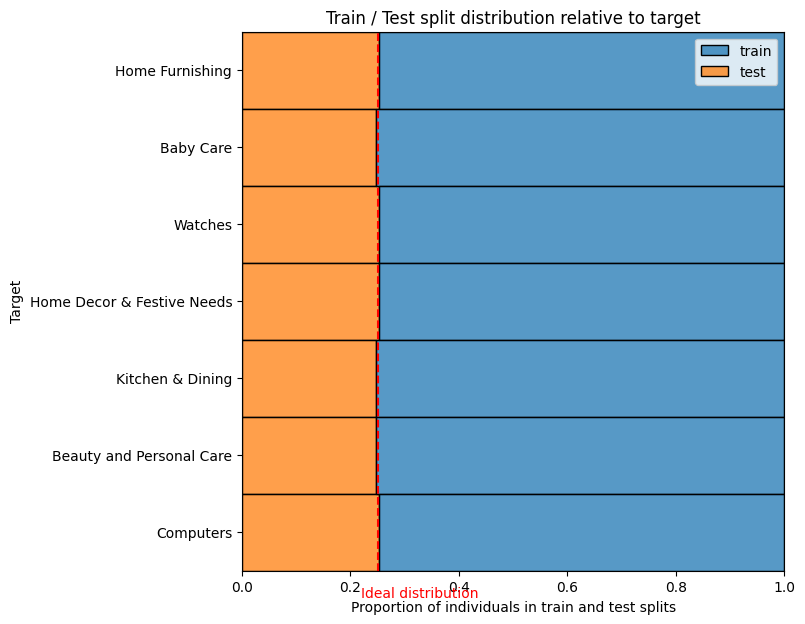

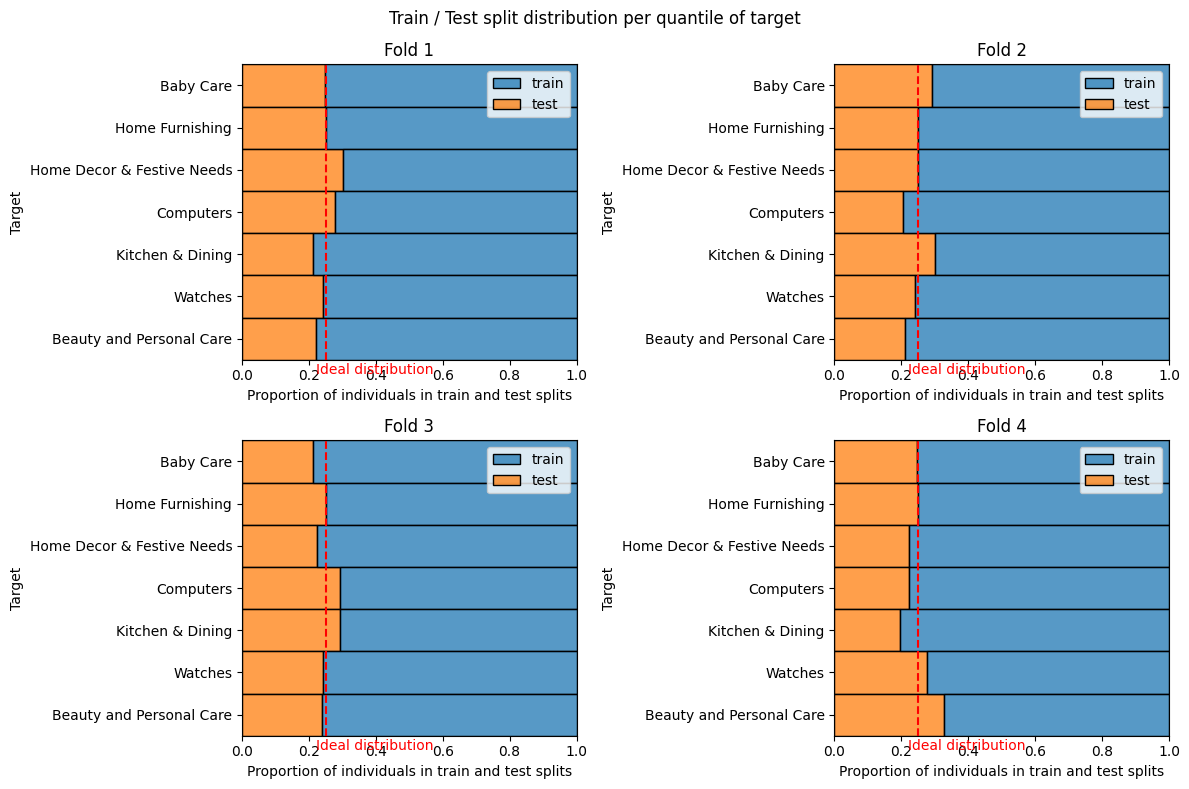

Cross validation results for pipeline 'CountVectorizer-98fa37f9_RidgeClassifier-428d7af7' was retrieved from utils\model_results\text-based_classification\CountVectorizer-98fa37f9_RidgeClassifier-428d7af7.pkl.


C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:204: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(comparison_results.drop_duplicates(['Pipeline'])['Pipeline'], rotation=45)


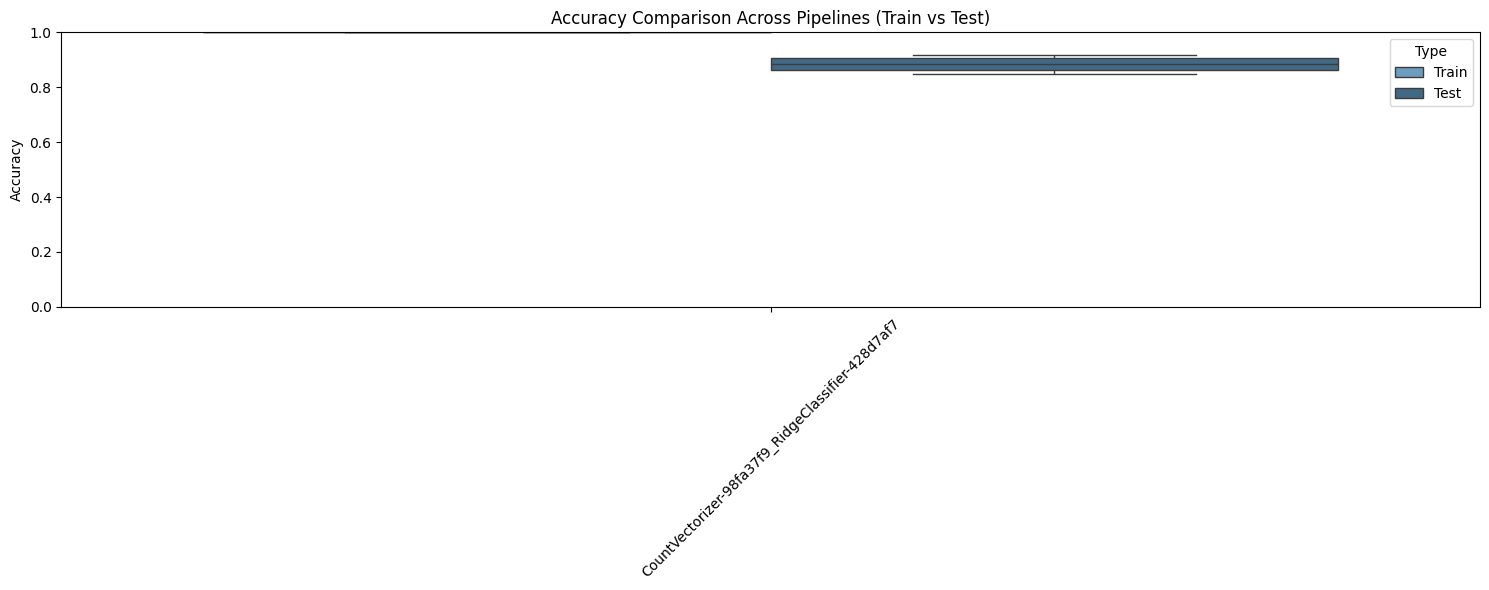

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:204: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(comparison_results.drop_duplicates(['Pipeline'])['Pipeline'], rotation=45)
C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:199: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


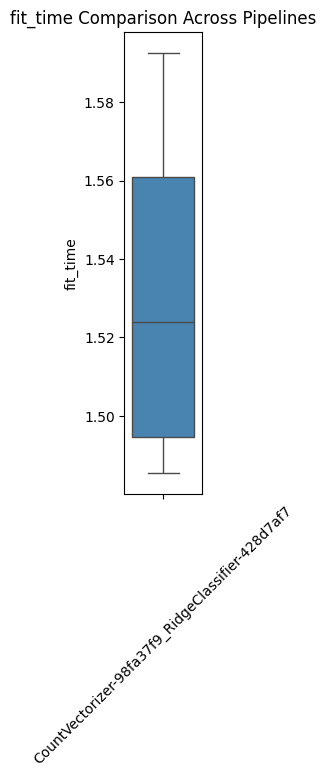

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:204: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(comparison_results.drop_duplicates(['Pipeline'])['Pipeline'], rotation=45)
C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:199: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


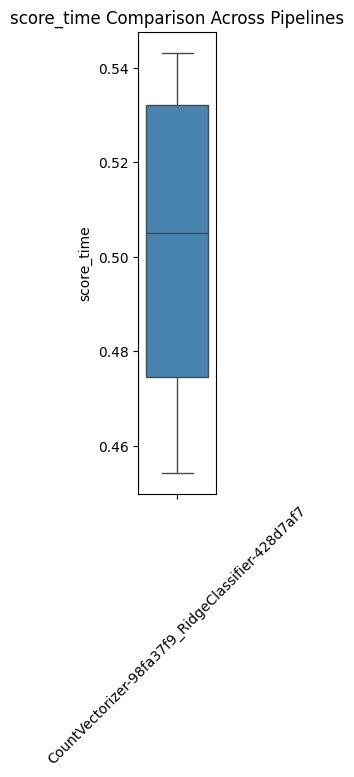

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:204: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(comparison_results.drop_duplicates(['Pipeline'])['Pipeline'], rotation=45)
C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:199: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


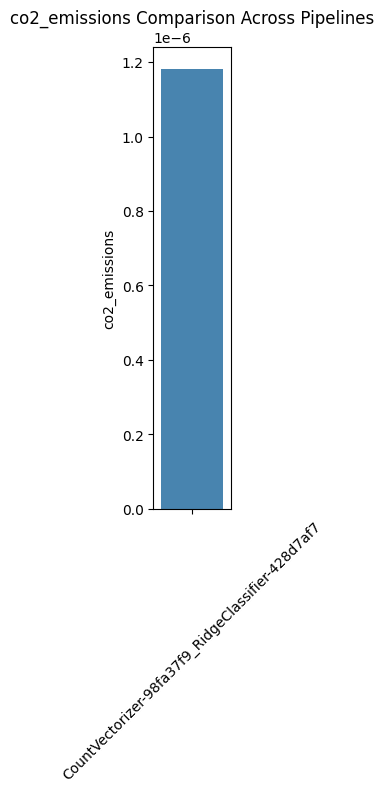

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\363465800.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fitted_vect = [estimator for estimator_name, estimator in fitted_pipelines[0].named_steps.items() if "vectorizer" in estimator_name]


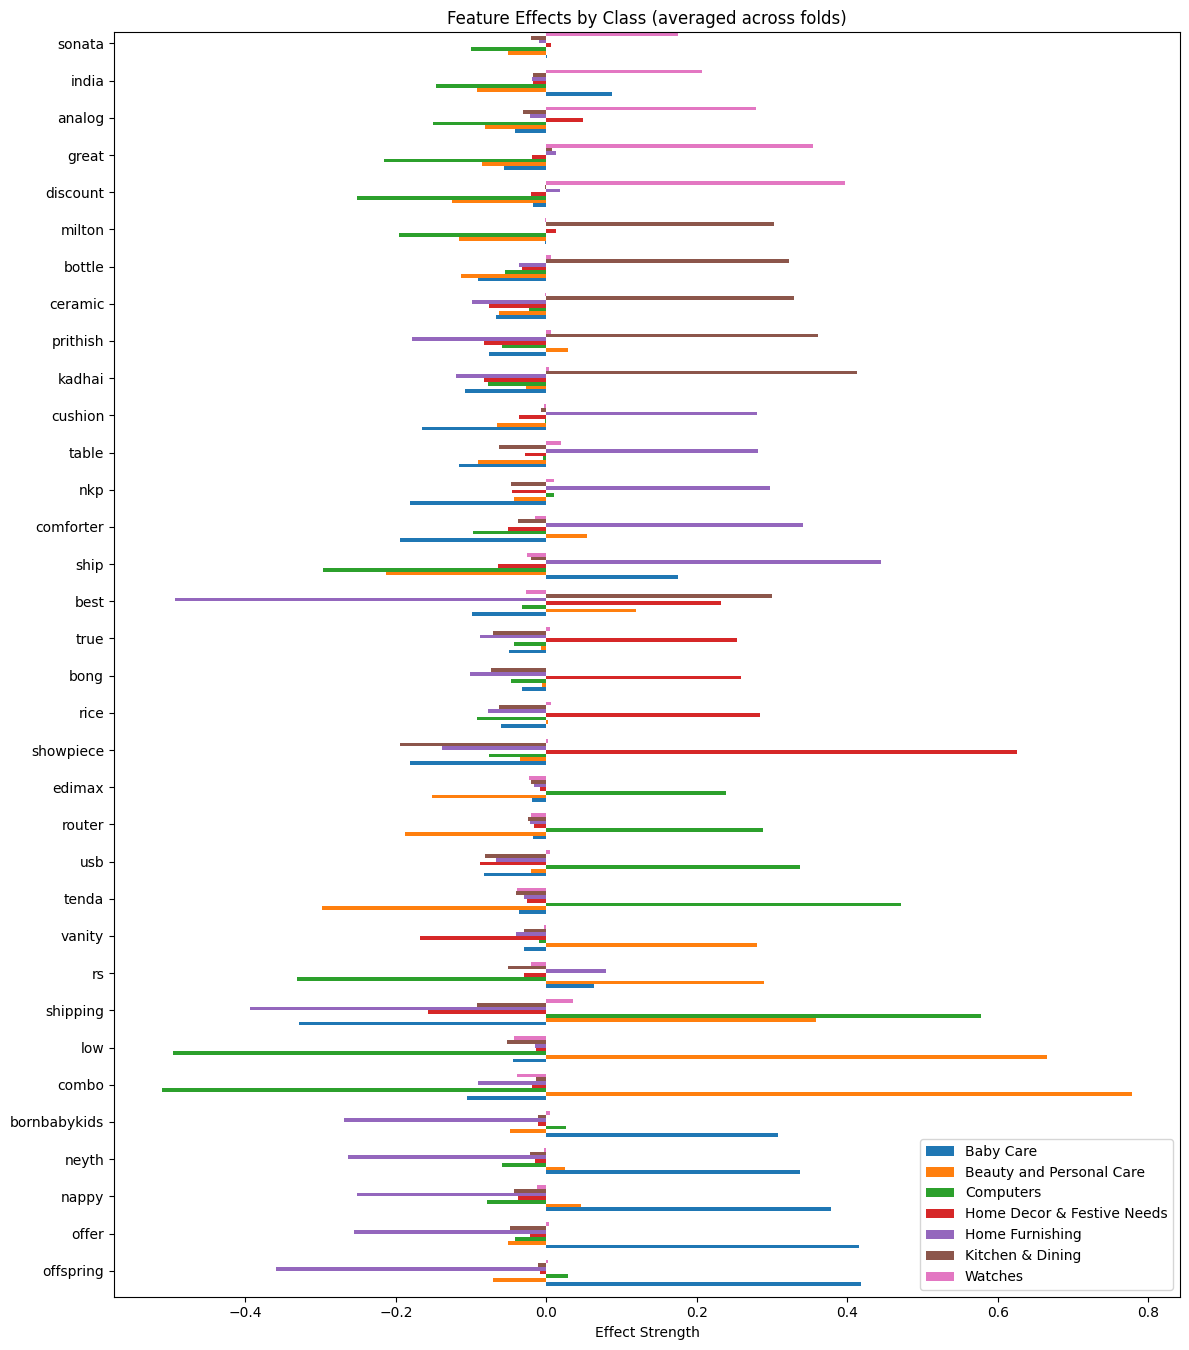

In [349]:
bow = TextClassifier(df=text_data, cv=KFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE), vect=CountVectorizer(tokenizer=lemmatize_text, stop_words=list(stopwords_lemma)), target="category_level_1", features=["description"], scores={'Accuracy':make_scorer(accuracy_score)})
bow.run()

## Bigrams

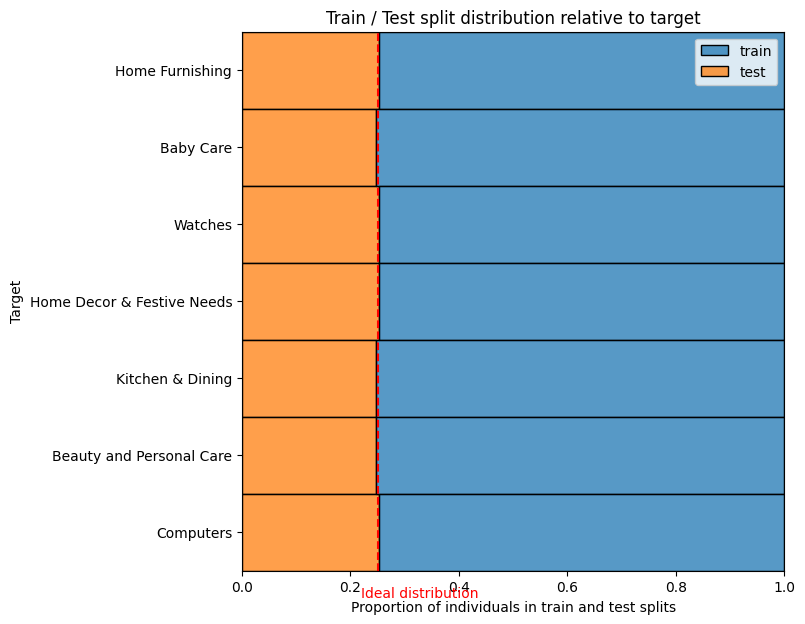

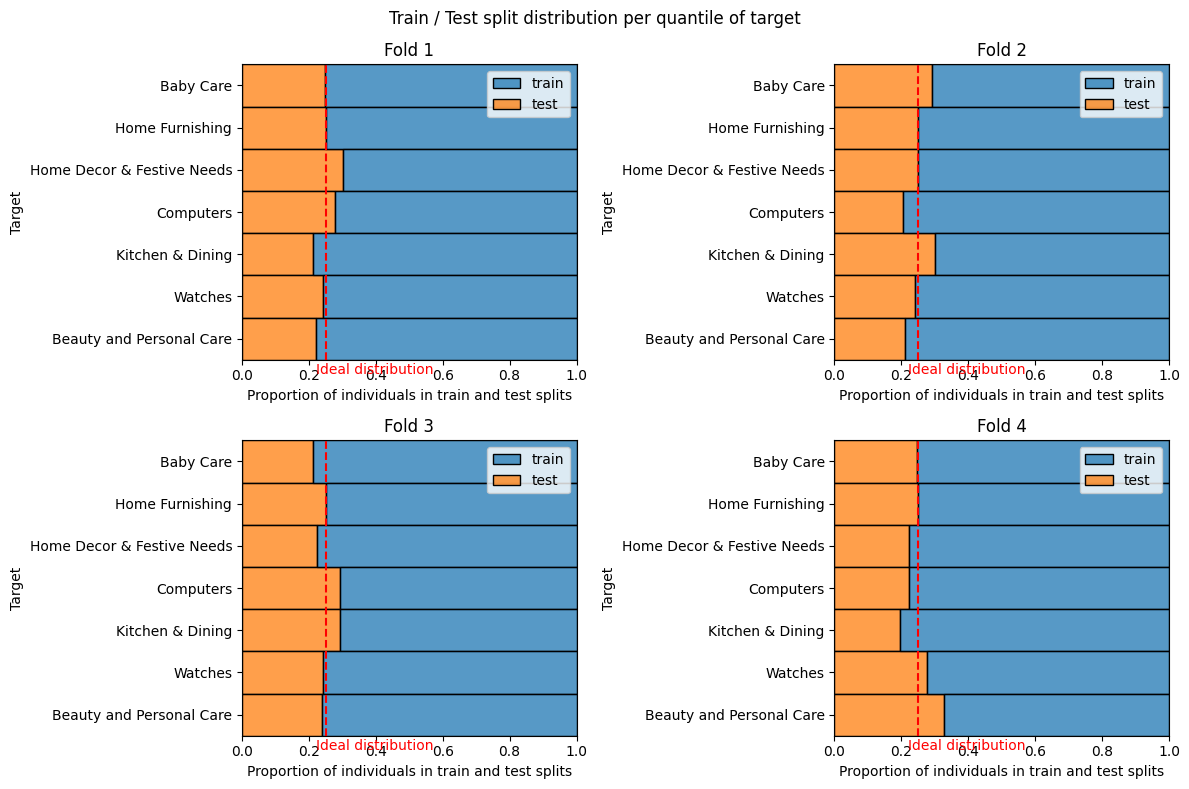

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:204: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(comparison_results.drop_duplicates(['Pipeline'])['Pipeline'], rotation=45)


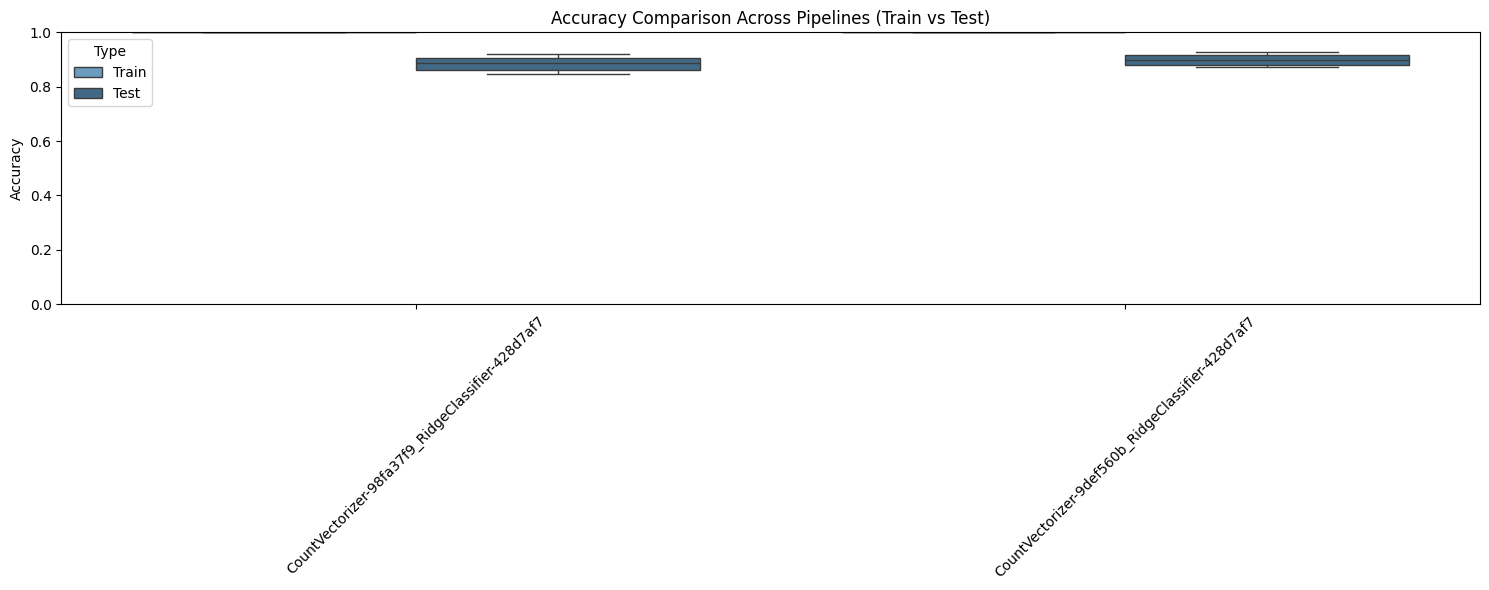

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:204: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(comparison_results.drop_duplicates(['Pipeline'])['Pipeline'], rotation=45)
C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:199: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


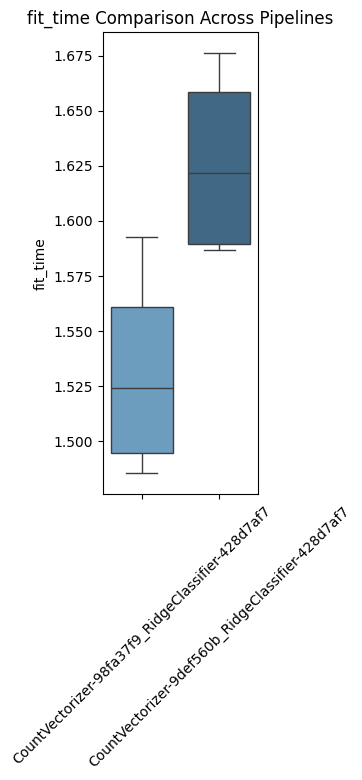

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:204: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(comparison_results.drop_duplicates(['Pipeline'])['Pipeline'], rotation=45)
C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:199: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


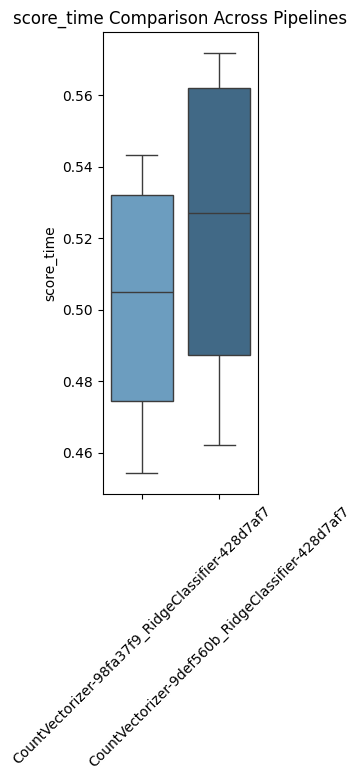

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:204: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(comparison_results.drop_duplicates(['Pipeline'])['Pipeline'], rotation=45)
C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:199: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


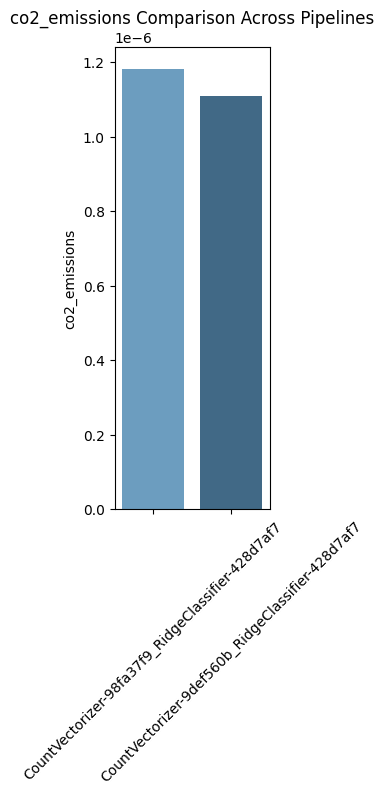

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\363465800.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fitted_vect = [estimator for estimator_name, estimator in fitted_pipelines[0].named_steps.items() if "vectorizer" in estimator_name]


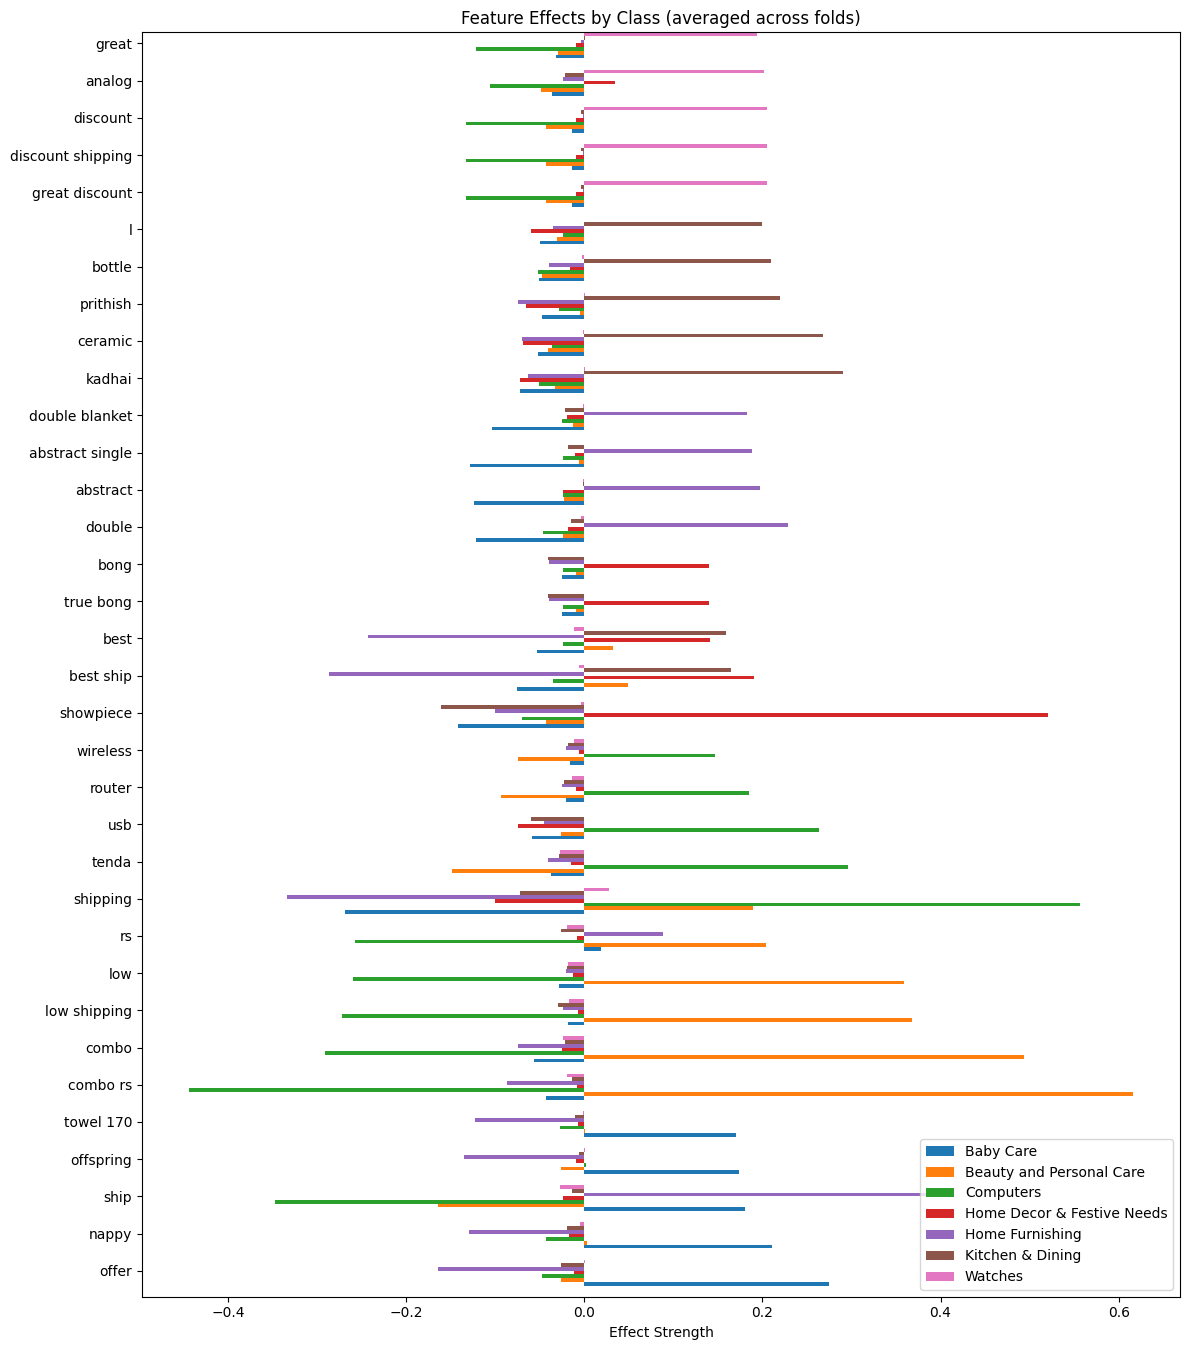

In [350]:
bow_bigrams = TextClassifier(df=text_data, cv=KFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE), vect=CountVectorizer(tokenizer=lemmatize_text, stop_words=list(stopwords_lemma), ngram_range=(1,2)), target="category_level_1", features=["description"])
bow_bigrams.run()

## Tfidf

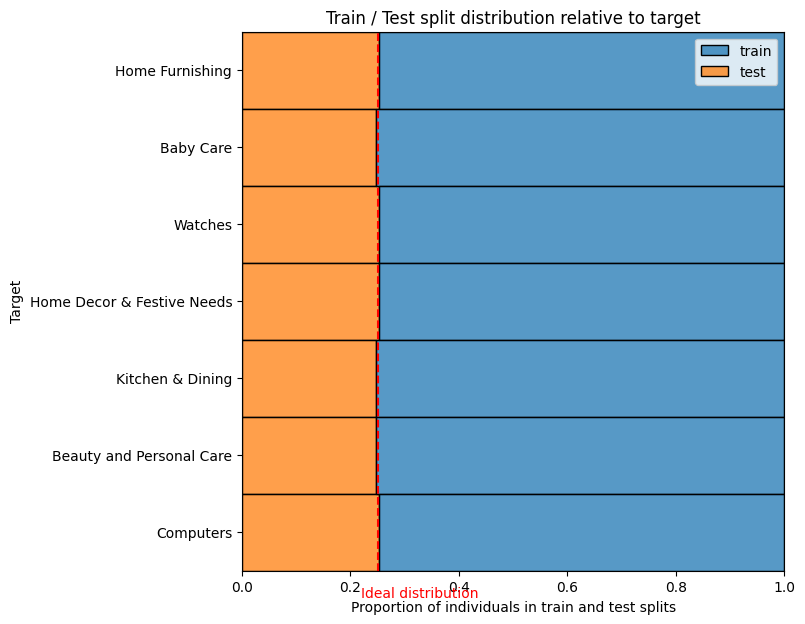

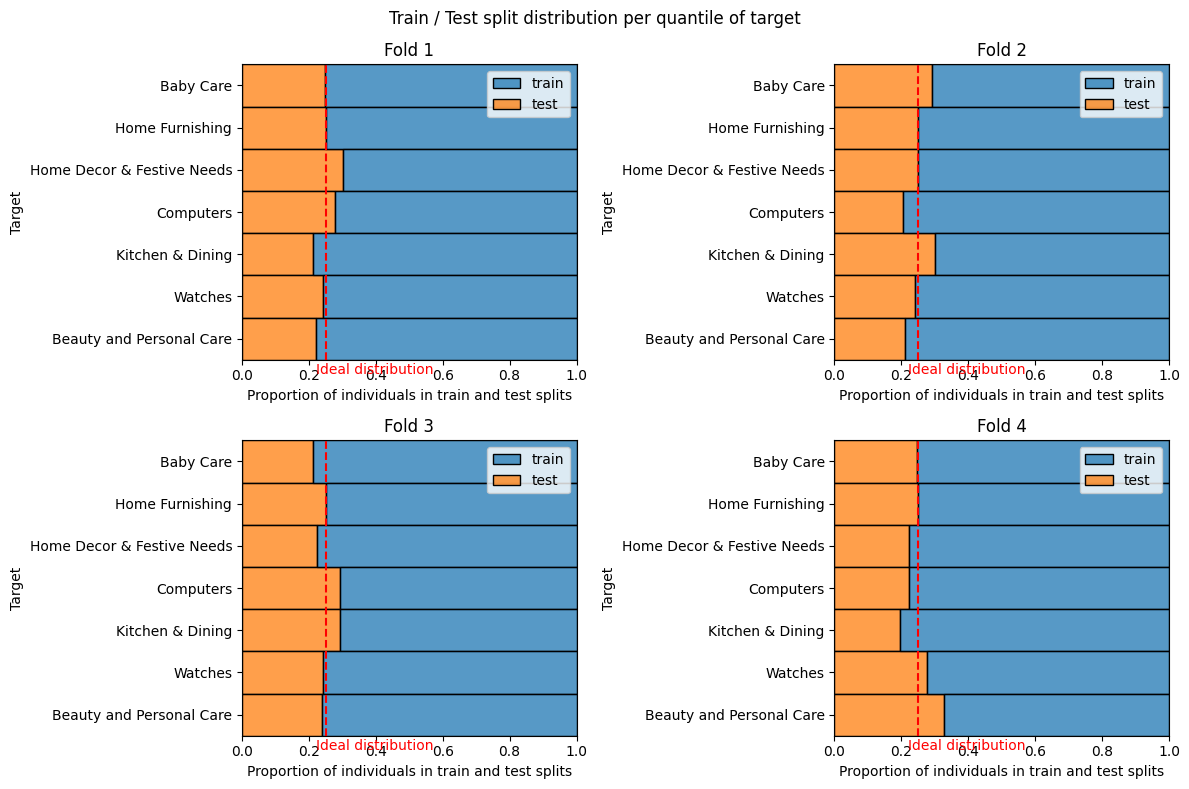

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:204: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(comparison_results.drop_duplicates(['Pipeline'])['Pipeline'], rotation=45)


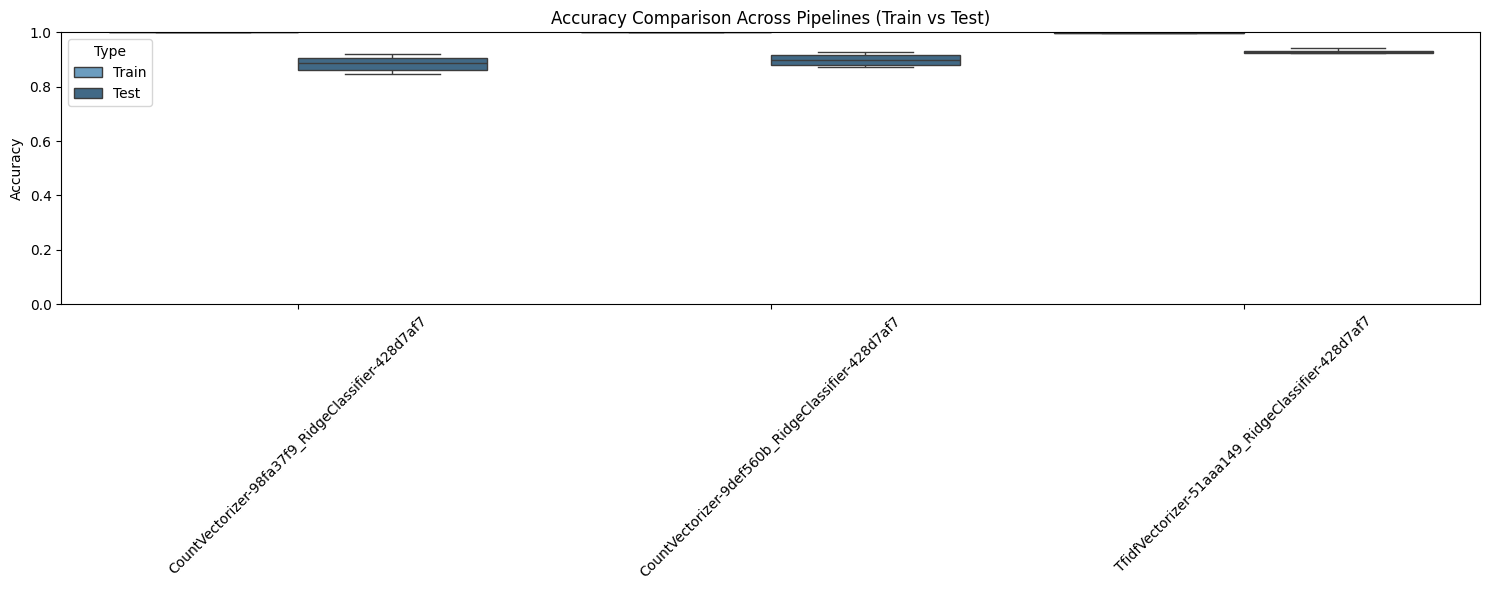

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:204: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(comparison_results.drop_duplicates(['Pipeline'])['Pipeline'], rotation=45)


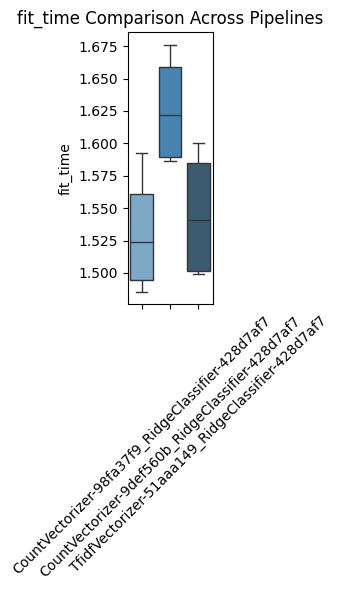

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:204: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(comparison_results.drop_duplicates(['Pipeline'])['Pipeline'], rotation=45)


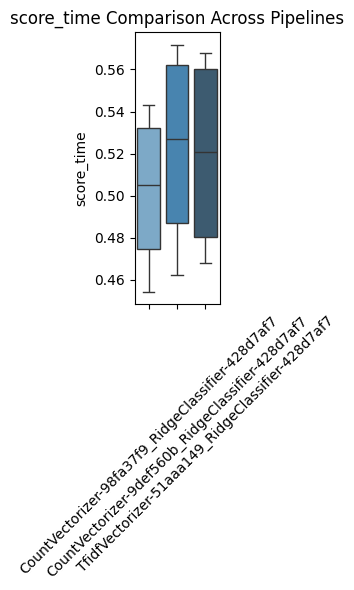

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\2976415574.py:204: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(comparison_results.drop_duplicates(['Pipeline'])['Pipeline'], rotation=45)


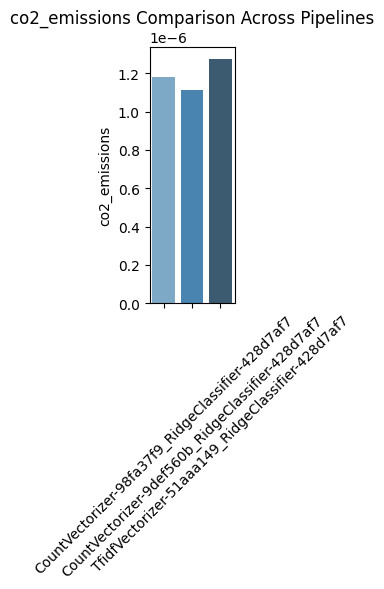

C:\Users\HCYF5290\AppData\Local\Temp\ipykernel_15220\363465800.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fitted_vect = [estimator for estimator_name, estimator in fitted_pipelines[0].named_steps.items() if "vectorizer" in estimator_name]


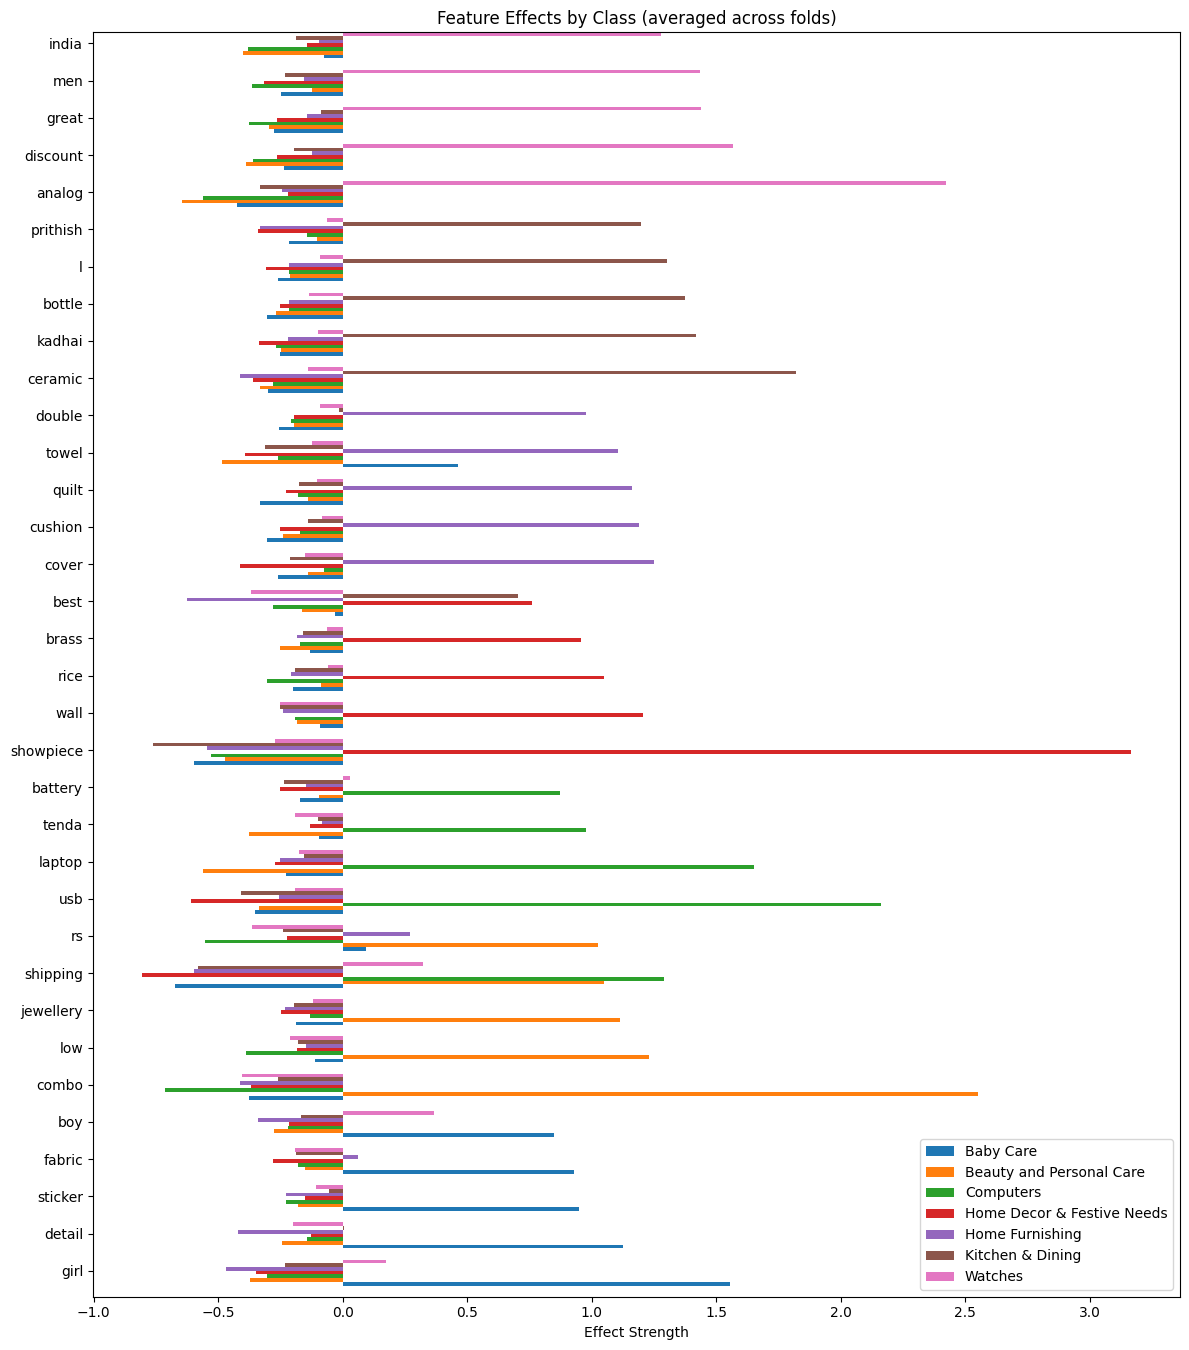

In [352]:
tfidf = TextClassifier(df=text_data, vect= TfidfVectorizer(tokenizer=lemmatize_text, stop_words=list(get_most_used_words(df=text_data, tokens_col="tokenized_lemma", threshold_words=2000, plot=False))), cv=KFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE), target="category_level_1", features=["description"])
tfidf.run()

In [354]:
test = pd.DataFrame({"true":tfidf.y_test, "pred":tfidf.clf_pred})
test["valid_pred"] = (test["true"] == test["pred"])
test["description"] = text_data.loc[text_data.index.isin(test.index), "description"]
test["description_length"] = test["description"].apply(len)

AttributeError: 'TextClassifier' object has no attribute 'clf_pred'

In [ ]:
sns.histplot(test.loc[test["valid_pred"] == False], y="pred", hue="pred", legend=False, shrink=0.8)
plt.title("Category distribution for wrongly categorized products")
plt.ylabel("Prediction")

In [ ]:
sns.scatterplot(test, x="valid_pred", y="description_length")
plt.title("Description length relative to prediction accuracy")
plt.ylabel("Description length")
plt.xlabel("Prediction is valid")

In [ ]:
test.loc[test["valid_pred"] == False, ["description", "pred", "true"]]

It seems like the errors come from :
- Non standard wording ("BabyBucket" instead of "Baby Bucket" ; "Mousepad" instead of "Mouse pad")
- Ambiguous description which does not really correspond the true category chosen by the vendor ("Baby Bucket" article categorized as "Home furnishing", "Blanket" categorized as "Baby Care")
- Errors due to lack of data ("hand juicer" or "tripod" might not be common articles)

Possible improvements :
- Use the "brand" information of the product
- Improve stopwords definition to reduce their impact and hopefully increase accuracy (for example remove "warranty", "ship", "shipping" which seem to have a great impact on the predictions)

Conclusion :
- The model is actually already decent, but those results should be confirmed using cross validation.

Tester avec des sous-catégories

## Clustering

### Using Standard Kmeans

In [ ]:
import numpy as np

num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=RANDOM_STATE)
kmeans.fit(vstack((tfidf.X_train, tfidf.X_test))) # Using already computed sparse matrix from tfidf

top_n = 10
terms = tfidf.vect.get_feature_names_out()

labels = kmeans.labels_

for i, center in enumerate(kmeans.cluster_centers_):
    # Get indices of top terms
    top_indices = center.argsort()[::-1][:top_n]
    top_terms = [terms[idx] for idx in top_indices]

    print(f"\nCluster {i}:")
    print(", ".join(top_terms))


In [ ]:
tsne = TSNE(n_components=2, perplexity=20, random_state=RANDOM_STATE, init='random')
X_tsne = tsne.fit_transform(vstack((tfidf.X_train, tfidf.X_test)))

# Plotting the clusters
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='tab20', marker='o', ax=axes[0])
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=pd.concat([tfidf.y_train["category_level_1"], tfidf.y_test["category_level_1"]], axis=0), palette='tab20', marker='o', ax=axes[1])

axes[0].set_title('t-SNE Visualization of clusters')
sns.move_legend(obj=axes[0], loc='upper left', bbox_to_anchor=(1,1))

axes[1].set_title('t-SNE Visualization of categories')
sns.move_legend(obj=axes[1], loc='upper left', bbox_to_anchor=(1,1))

plt.show()

In [ ]:
from coclust.clustering import SphericalKmeans

In [ ]:
import numpy as np

num_clusters = 7
sph_kmeans = SphericalKmeans(n_clusters=num_clusters, random_state=RANDOM_STATE)
# Using spherical Kmeans instead of standard Kmeans allows to be less sensitive to the length of each document (description)
sph_kmeans.fit(vstack((tfidf.X_train, tfidf.X_test))) # Using already computed sparse matrix from tfidf

top_n = 10
terms = tfidf.vect.get_feature_names_out()

spherical_labels = sph_kmeans.labels_

for i, center in enumerate(sph_kmeans.cluster_centers_):
    # Convert sparse row to dense 1D array
    dense_center = center.toarray().flatten()

    # Get indices of top terms
    top_indices = dense_center.argsort()[::-1][:top_n]
    top_terms = [terms[idx] for idx in top_indices]

    print(f"\nCluster {i}:")
    print(", ".join(top_terms))


In [ ]:
tsne = TSNE(n_components=2, perplexity=20, random_state=RANDOM_STATE, init='random')
X_tsne = tsne.fit_transform(vstack((tfidf.X_train, tfidf.X_test)))

# Plotting the clusters
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=spherical_labels, palette='tab20', marker='o', ax=axes[0])
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=pd.concat([tfidf.y_train["category_level_1"], tfidf.y_test["category_level_1"]], axis=0), palette='tab20', marker='o', ax=axes[1])

plt.title('t-SNE Visualization of Clusters')
sns.move_legend(obj=axes[0], loc='upper left', bbox_to_anchor=(1,1))
sns.move_legend(obj=axes[1], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

Using Spherical Kmeans actually does not seem better than standard Kmeans.

## Word2Vec

In [ ]:
from gensim.models import Word2Vec
import gensim

In [ ]:
text_data

In [ ]:
w2v = Word2Vec(text_data["tokenized_lemma_no_sw"], min_count=1,
                                vector_size=100, window=5)

In [ ]:
words = list(w2v.wv.key_to_index)

In [ ]:
w2v.wv.similarity("blanket", "computer")

Aggrégation avec moyenne pondérée dont les poids viennent du tfidf

## BERT

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
class SentenceTransformerVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name="all-MiniLM-L6-v2"):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)
    
    def fit(self, X, y=None):
        return self  # nothing to learn
    
    def transform(self, X):
        return self.model.encode(X.tolist(), show_progress_bar=False)


Batches: 100%|██████████| 9/9 [00:01<00:00,  4.98it/s]
c:\Git-OpenClassrooms\DS_6\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


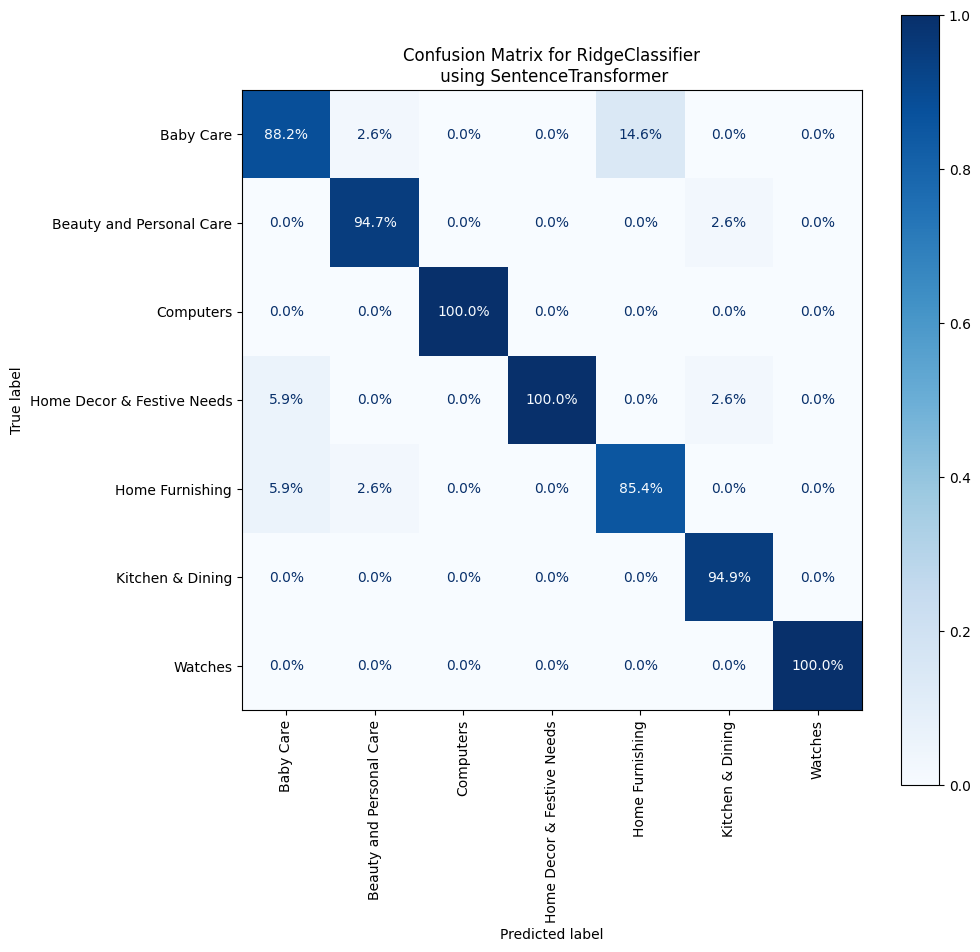

In [ ]:
s_transformers = TextClassifier(text_data, cv=KFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE), target="category_level_1", features=["description"], vect=SentenceTransformer('all-MiniLM-L6-v2'))
s_transformers.vectorize()
s_transformers.classify(conf_matrix_figsize=(10,10))

In [ ]:
test = pd.DataFrame({"true":s_transformers.y_test["category_level_1"], "pred":s_transformers.clf_pred})
test["valid_pred"] = (test["true"] == test["pred"])
test["description"] = text_data.loc[text_data.index.isin(test.index), "description"]
test["description_length"] = test["description"].apply(len)

Text(0, 0.5, 'Prediction')

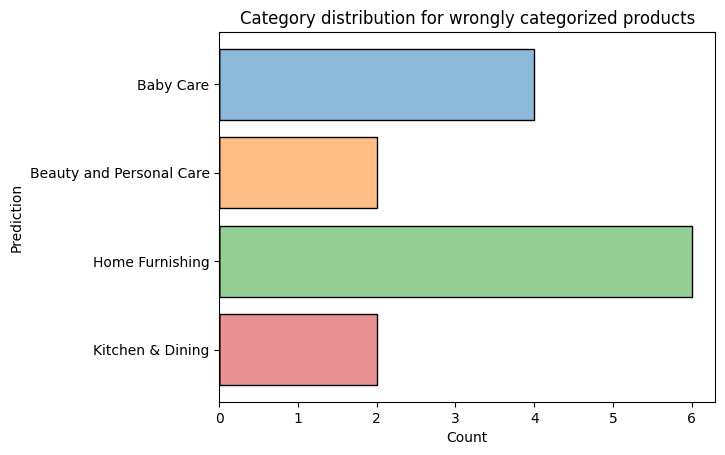

In [ ]:
sns.histplot(test.loc[test["valid_pred"] == False], y="pred", hue="pred", legend=False, shrink=0.8)
plt.title("Category distribution for wrongly categorized products")
plt.ylabel("Prediction")

Text(0.5, 0, 'Prediction is valid')

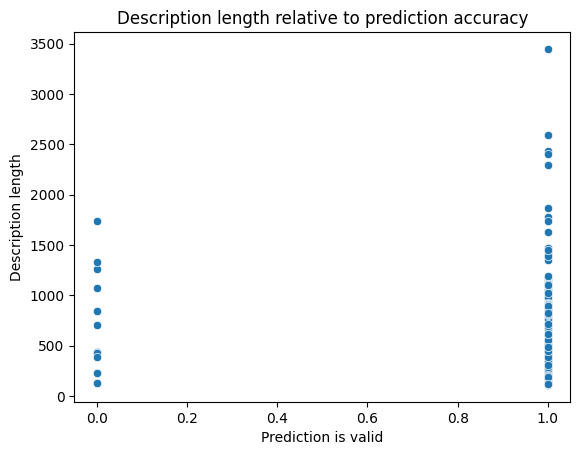

In [ ]:
sns.scatterplot(test, x="valid_pred", y="description_length")
plt.title("Description length relative to prediction accuracy")
plt.ylabel("Description length")
plt.xlabel("Prediction is valid")

In [ ]:
test.loc[test["valid_pred"] == False, ["description", "pred", "true"]]

description  \
895   Just Linen Cotton Bath Towel (2 Terry Bath Tow...   
1009  Key Features of Wall Decal Small Self Adhesive...   
996   Key Features of L Oreal Eversleek Sulfate - Fr...   
967   Key Features of Mahadev Handicrafts Cotton Car...   
658   Buy Creative Width Decor Medium Vinyl Sticker ...   
773   Buy Ireeya Abstract Single Coral Blanket Blue ...   
898   Specifications of KDS SURGICAL Tripod Walking ...   
672   Indha Craft Cloth Photo Frame (Photo Size - 12...   
2     Key Features of Eurospa Cotton Terry Face Towe...   
36    Myesquire Ceramic Burner Pot Lemongrass Liquid...   
968   Key Features of Sparklings Cotton Checkered Do...   
920   Buy Baby Bucket Cartoon Single Blanket blue at...   
870   Bianca Cotton Face Towel Set (Face Towel Set, ...   
624   Specifications of Oxolloxo Solid Single Breast...   

                          pred                        true  
895                  Baby Care             Home Furnishing  
1009                 Baby Care  Home Decor & Festive Needs  
996   Beauty and Personal Care                   Baby Care  
967            Home Furnishing                   Baby Care  
658                  Baby Care  Home Decor & Festive Needs  
773            Home Furnishing                   Baby Care  
898           Kitchen & Dining    Beauty and Personal Care  
672            Home Furnishing                   Baby Care  
2              Home Furnishing                   Baby Care  
36            Kitchen & Dining  Home Decor & Festive Needs  
968            Home Furnishing                   Baby Care  
920                  Baby Care             Home Furnishing  
870   Beauty and Personal Care             Home Furnishing  
624            Home Furnishing                   Baby Care

Transformers -> matrice d'attention -> Sur quelle partie de la phrase se focalise le modèle

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset

# Encodage des labels
encoder = LabelEncoder()
labels = encoder.fit_transform(text_data["category_level_1"])

# Conversion en Dataset Hugging Face
dataset = pd.DataFrame({
    "text": text_data["description"],
    "labels": labels
})

# Tokenizer BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(series:pd.Series):
    return tokenizer(series, padding="max_length", truncation=True, max_length=128)

dataset = Dataset.from_pandas(dataset)


dataset = dataset.map(tokenize, input_columns="text", batched=True)
dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
print(dataset)


Map: 100%|██████████| 1050/1050 [00:01<00:00, 1037.69 examples/s]

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1050
})


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=7)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
split_dataset = dataset.train_test_split(test_size=0.25)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

In [143]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

trainer.train(resume_from_checkpoint=True)

c:\Git-OpenClassrooms\DS_6\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

weight and biaises library

In [ ]:
text = "New connected watch"
inputs = tokenizer(text_data["category_level_1"], return_tensors="pt", truncation=True, padding=True)
outputs = model(**inputs)
pred = torch.argmax(outputs.logits, dim=1).item()

print("Catégorie prédite :", encoder.inverse_transform([pred])[0])


Catégorie prédite : Watches


In [112]:
predictions = trainer.predict(eval_dataset)

Text(0.5, 1.0, 'Confusion Matrix for BERT')

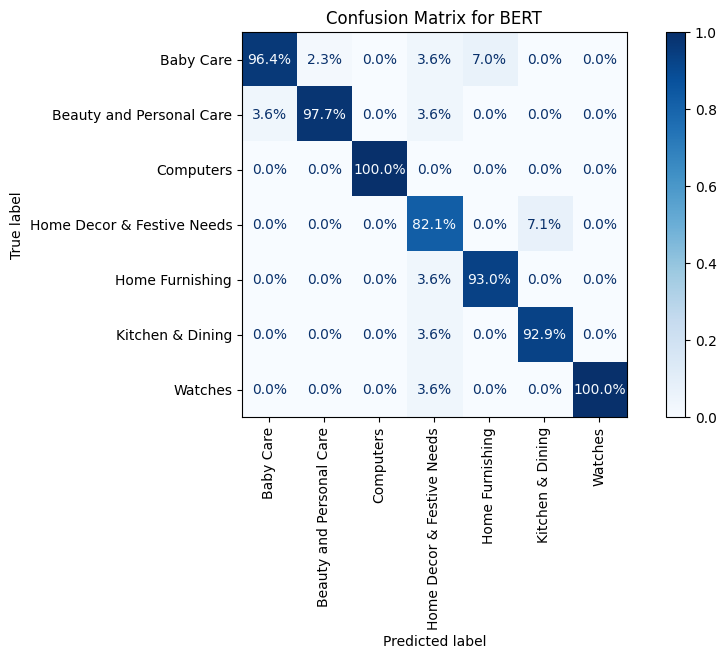

In [113]:
y_pred = encoder.inverse_transform(np.argmax(predictions.predictions, axis=1))
y_true = encoder.inverse_transform(predictions.label_ids)

fig, ax = plt.subplots(figsize=(10,5))
cm_normalized = confusion_matrix(y_true, y_pred, normalize="pred")
disp = ConfusionMatrixDisplay(
	confusion_matrix=cm_normalized,
	display_labels=np.unique(y_true)
)

# Plot with percentage format
disp.plot(ax=ax, values_format='.1%', cmap='Blues')

# ConfusionMatrixDisplay.from_predictions(self.y_test, self.clf_pred, ax=ax)
ax.tick_params(axis='x', rotation=90)
ax.set_title(f"Confusion Matrix for BERT")

## USE

## About intellectual property

## Tag clouds

## PCA

## LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 20

# Créer le modèle LDA
lda = LatentDirichletAllocation(
		n_components=n_topics, 
		max_iter=5, 
		learning_method='online', 
		learning_offset=50.,
		random_state=0)

# Fitter sur les données
lda.fit(tf)

def display_topics(model, feature_names, no_top_words):
	for topic_idx, topic in enumerate(model.components_):
		print("Topic {}:".format(topic_idx))
		print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)

## NMF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
	min_df=2, 
	max_features=no_features, 
	stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf)

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)

## UMAP

In [ ]:
text_data

bag of words = juste compter la fréquence des mots dans chaque texte ?
Est-ce que je m'appuie uniquement sur description pour ce projet ou je suis libre et peut utiliser d'autres features éventuellement ? -> Name + Description (+ brand éventuellement)